# Variational Inference for Gaussian Process Classification Models

#### By Wu Lin - <a href="mailto:yorker.lin@gmail.com">yorker.lin@gmail.com</a> - <a href="https://github.com/yorkerlin">https://github.com/yorkerlin</a> Suggested by Heiko Strathmann and Mohammad Emtiyaz Khan 

#### Based on the notebook of Gaussian Processes by Heiko Strathmann - <a href="mailto:heiko.strathmann@gmail.com">heiko.strathmann@gmail.com</a> - <a href="https://github.com/karlnapf">github.com/karlnapf</a> - <a href="http://herrstrathmann.de">herrstrathmann.de</a>, and the GP framework of the Google summer of code 2014 project of Wu Lin,  - Google summer of code 2013 project of Roman Votyakov - <a href="mailto:votjakovr@gmail.com">votjakovr@gmail.com</a> - <a href="https://github.com/votjakovr">github.com/votjakovr</a>, and the Google summer of code 2012 project of Jacob Walker - <a href="mailto:walke434@gmail.com">walke434@gmail.com</a> - <a href="https://github.com/puffin444">github.com/puffin444</a> 

A <a href="http://en.wikipedia.org/wiki/Gaussian_process">Gaussian process</a> (GP) model is a flexible model, which can be used to do <a href="http://en.wikipedia.org/wiki/Regression_analysis">regression</a>, <a href="http://en.wikipedia.org/wiki/Statistical_classification">classification</a>, <a href="http://en.wikipedia.org/wiki/Dimensionality_reduction">dimension reduction</a>, and <a href="http://en.wikipedia.org/wiki/Deep_learning">deep learning</a>. A GP model is a <a href="http://en.wikipedia.org/wiki/Category:Non-parametric_Bayesian_methods">Bayesian non-parametric model</a> using <a href="http://en.wikipedia.org/wiki/Kernel_method">kernel methods</a>.
This notebook describes how to do <a href="http://en.wikipedia.org/wiki/Variational_Bayesian_methods">variational inference</a> for Gaussian Process Classification (GPC) models in Shogun. In a GPC model, a set of GP functions are used to predict a discrete label given its features of a data point.

For the theory about GPC, we assume that readers have some background in <a href="http://en.wikipedia.org/wiki/Bayesian_statistics">Bayesian statistics</a> and basic knowledge of Gaussian Processes. For the background, please see the <a href="http://www.shogun-toolbox.org/static/notebook/current/gaussian_processes.html">notebook</a> or <a href="http://nbviewer.ipython.org/github/AM207/2015/blob/master/Lectures/Lecture21_GaussianProcesses.ipynb">another notebook</a> about Gaussian Processes. After providing a semi-formal introduction, we illustrate how to do training, make predictions, and automatically learn parameters of GPC models (model selection) in Shogun.

## <a id='toc'>Table of Content</a>

* <a href='#overview'>Overview</a> 
    * <a href="#benefit">Benefits of Using GP Models in Shogun</a>
    * <a href="#roadmap">Roadmap of GP Models in Shogun</a>
* <a href="#intro">Brief Introduction</a>
* Theory (Skip if you just want code examples)
 * <a href="#bigpic">Big Picture of Variational Inference for GPC Models</a>
 * <a href="#detailbg">More Detailed Background about GPC Models</a>
 * <a href="#VGI">Variational Gaussian Inference for GPC Models</a>
 * <a href="#nonclosedForm">Dealing with the Non-closed Form Issue in GPC Models</a>
 * <a href="#bgvb">Some Background of Variational Bounds in GPC Models</a>
 * <a href="#difficulty">Difficulty of Scaling up standard GPC Models</a> 
 * <a href="#sparseGP">Big Picture of Sparse GPC Models for Large Scale Inference</a>  
 * <a href="#ref">References</a>
* Summary (Shogun's API) 
 * <a href='#likelihood'>Likelihood Classes for GPC Models in Shogun</a>
 * <a href="#inference">Inference Methods for GPC Models in Shogun</a>
 * <a href='#opt'>Optimizers Used in Inference Methods (for advanced users)</a>
 * <a href='#linesearch'>Line Search Methods Used in LBFGS Optimizer (for advanced users)</a>
* Code Examples
 * <a href='#toy'>A Toy Example of Variational Gaussian Inference</a>
 * <a href='#visu'>An Example for Visualization (banana dataset)</a>
     * <a href="#largescale">A Glimpse of Large Scale Inference Methods</a> 
     * <a href="#optInd">Optimizing Inducing Points</a>       
 * <a href="#realeg1">A Real-World Example (sonar dataset)</a>
 * <a href="#realeg2">Another Real-world Example (USPS dataset)</a>
     * <a href='#laplace'>Using Laplace Method</a>
     * <a href='#covv'>Using Covariance Variational Method</a>
     * <a href='#meanfield'>Using Mean-field Variational Method</a>
     * <a href="#dual">Using Dual Variational Method</a>
     * <a href="#chol">Using Cholesky Variational Method</a>
     * <a href="#bounds">Likelihood Classes Supported Variational Bounds</a> 
     * <a href='#parameters'>Optimizing Parameters of GPC (Model Selection)</a>
* <a href='#todo'>Soon to Come</a>
 * More Large Scale inference methods for GPC Models
 * Latent GP Models for Dimension Reduction

In [2]:
%matplotlib inline
# import all shogun classes
import os
SHOGUN_DATA_DIR=os.getenv('SHOGUN_DATA_DIR', '../../../../data')
import shogun as sg

# import all required libraries
import scipy
import scipy.io
import numpy as np
from math import exp,sqrt,log   
import random
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from typing import List

## <a id='overview'>Overview</a> <a href='#toc'>[TOP]</a>

### <a id="benefit">Benefits of Using GP Models in Shogun</a> <a href='#toc'>[TOP]</a>

* Unified API across <font color='red'>10</font> major languages (Python, R, Octave, Java, and more)
* Better performance (written in C++ and parallel computing) compared to <a href="http://scikit-learn.org/">scikit-learn</a> and <a href="http://www.gaussianprocess.org/gpml/code/">GPML</a> (TODO adding some speedup statistics)
* More (<font color='red'>6</font> metnods) medium-scale variational inference methods compared to scikit-learn and GPML
* More (<font color='red'>8</font> methods, including 5 ongoing) large-scale variational inference methods compared to scikit-learn and GPML
* Efficient implementation of more than <font color='red'>25</font> kernels (covariance functions)
* Supporting GP multi-classification

### <a id="roadmap">Roadmap of GP Models in Shogun</a> <a href='#toc'>[TOP]</a>

* Inference methods for Standard GP models
    * Exact method for GP regression models
    * Variational methods for GP classification models
    
* Inference methods for sparse GP models (also known as large scale inference methods)
    * Fully Independent Training Conditional (FITC) methods for GP regression models
    * FITC Laplace methods for GP classification models
    * FITC KL methods for GP regression and classification models 
    * Parallel/Distributed Variational Inference for GP regression and classification models (Ongoing)
    * Stochastic Variational Inference for GP regression and classification models (Ongoing)
    * Nonparametric Variational Inference for GP regression and classification models (TODO)

* Beyond GP models for regression and classification
    * GP latent variable models for dimension reduction (Ongoing)
    * Deep GP models for deep learning (TODO)

## <a id='intro'>Brief Introduction</a> <a href='#toc'>[TOP]</a>

In this notebook, we mainly focus on binary classification problems. It is not hard to exend the presented methodology to multi-classifcation problems.   Given a binary classification problem, binary labels and features are respectively defined as a column vector, $\mathbf{y}\in\mathcal{Y}^n=\{-1,+1\}^n$, and a matrix, $\mathbf{X}\in\mathcal{R}^{n\times d}$, where $n$ is the number of data points and $d$ is the number of features.  A likelihood function $p(\mathbf{y}|\text{f},\mathbf{X})=p(\mathbf{y}|\mathbf{f})$ is used to model data with labels, where a latent function $\text{f}:\mathcal{R}^{d}\to \mathcal{R} $ is drawn from a GP prior and $\text{f}(\mathbf{X})=\mathbf{f} \in \mathcal{R}^{n}$ is a column vector by applying $\text{f}$ to each row of $\mathbf{X}$. Given data with labels, our goal is to train a GP classifier ($p(\text{f}|\mathbf{y},\mathbf{X} $)) to fit the data well and predict new data points ($p(y_\text{new}|\mathbf{y},\mathbf{X},\mathbf{x}_\text{new})$). The following sections cover detailed background of variational inference for GPC models.

Note that the difference between $\text{f}$ and $\mathbf{f}$ is that $\text{f}$ is a function while $\mathbf{f}$ is a n-dimensional vector. The GP prior, $p(\text{f})$, and $p(\mathbf{f})=p(\text{f}(\mathbf{X}))$ are also different because $p(\text{f})$ is a distribution in an infinite dimensional (function) space while $p(\mathbf{f})$ is a distribution in a finite dimensional real space.


To gain some intuition how these GPC models behave, and how well variational Gaussian inference methods approximate posteriors, please see section <a href='#toy'>A Toy Example of Variational Gaussian Inference</a> and section <a href='#visu'>An Example of for Visualization</a>.

## <a id='bigpic'>Big Picture of Variational Inference for GPC Models</a> <a href='#toc'>[TOP]</a>

We want to learn posterior, $p(\text{f}|\mathbf{y},\mathbf{X}) \propto p(\mathbf{y}| \text{f},\mathbf{X}) \times p(\text{f}|\mathbf{X}) $, given training data points. Note that $p(\text{f})$ is the prior over the GP functions. We will see in <a href='#detailbg'>next section</a> that all we need is to learn $p(\mathbf{f}|\mathbf{y})=p(\text{f}(\mathbf{X})|\mathbf{y},\mathbf{X})$, which is a distribution in an finite dimensional space. (Recall that we use $\mathbf{f}$ as $\text{f}(\mathbf{X})$ and $p(\mathbf{f}|\mathbf{y})$ as $p(\text{f}(\mathbf{X})|\mathbf{y},\mathbf{X})$ for short).

The key intuition of variational inference is to approximate the distribution of interest (here $p(\mathbf{f}|\mathbf{y})$, which is a non-Gaussian distribution) with a more tractable distribution (for variational Gaussian inference, a Gaussian $q(\mathbf{f}|\mathbf{y}))$, via minimizing the <a href="http://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence">Kullback–Leibler divergence</a> (KL divergence) 

$${\mathrm{KL}}(Q\|P) = \int_{-\infty}^\infty \ln\left(\frac{q(\mathbf{f}|\mathbf{y})}{p(\mathbf{f}|\mathbf{y})}\right) q(\mathbf{f}|\mathbf{y}) \ {\rm d}\mathbf{f}$$

between the true distribution and the approximation.

Please see <a id='detailbg'>next section</a> if you want to know the reason why making prediction of GPC is not easy when $p(\mathbf{f}|\mathbf{y})$ is non-Gaussian. Therefore, we want to use a more tractable distribution $q(\mathbf{f}|\mathbf{y}))$ to perform prediction

Throughout this notebook, we deal with binary classification problems using <a href="http://en.wikipedia.org/wiki/Logit">inverse-logit</a>, (also known as Bernoulli-logistic function)
likelihood to model labels, given by 

$p(\mathbf{y}|\mathbf{f})=\prod_{i=1}^n p(y_\text{i}|\text{f}(\mathbf{X}_\text{i}))=\prod_{i=1}^n \frac{1}{1+\exp(-y_\text{i} \mathbf{f}_\text{i})}$,
where $\mathbf{f}_\text{i}$ is the i-th row of $\mathbf{X}$ and $\text{f}(\mathbf{X}_\text{i})=\mathbf{f}_\text{i}$

Note that In GPC models we implicitly assume that $\mathbf{y}$ are **conditional independent** if (latent) $\mathbf{f}$ are known.



## <a id='detailbg'>More Detailed Background about GPC Models</a> <a href='#toc'>[TOP]</a>

In GPC models, our goal is to predict the label, $y_\text{new}$, of a new data point, a row vector, $\mathbf{x}_\text{new}\in\mathcal{R}^{d}$ based on $p(y_\text{new}|\mathbf{y},\mathbf{X},\mathbf{x}_\text{new})$. 
According to <a href="http://en.wikipedia.org/wiki/Bayes%27_theorem">Bayes' theorem</a>, we know that <a href="http://en.wikipedia.org/wiki/Posterior_predictive_distribution"> the posterior predictive distribution</a> is    $$p(y_\text{new}|\mathbf{y},\mathbf{X},\mathbf{x}_\text{new})= \int {p(y_\text{new}|\text{f},\mathbf{x}_\text{new})p(\text{f}|\mathbf{y},\mathbf{X}) d\text{f}}$$ 
Informally, according to <a href="http://en.wikipedia.org/wiki/Multivariate_normal_distribution#Marginal_distributions">the property</a> of GP about marginalization, we have:

$$\int {p(\mathbf{y}_\text{new}|\text{f},\mathbf{x}_\text{new})p(\text{f}|\mathbf{y},\mathbf{X}) d\text{f}}= \int {p(\mathbf{y}_\text{new}|\text{f}(\mathbf{x}_\text{new}),\mathbf{x}_\text{new})p(\text{f}(\mathbf{x}_\text{new})|\mathbf{y},\mathbf{X}) d\text{f}(\mathbf{x}_\text{new})} = \int {p(\mathbf{y}_\text{new}|\mathbf{f}_\text{new})p(\mathbf{f}_\text{new}|\mathbf{y},\mathbf{X}) d\mathbf{f}_\text{new}} $$.

where $\text{f}(\mathbf{x}_\text{new})=\mathbf{f}_\text{new}$, $p(\mathbf{y}_\text{new}|\mathbf{f}_\text{new})=p(\mathbf{y}_\text{new}|\text{f},\mathbf{x}_\text{new})$ .

The key difference here is that $p(\text{f}|\mathbf{y}, \mathbf{X})$ is a distribution in an infinite dimensional space while $p(\mathbf{f}_{new}|\mathbf{y},\mathbf{X})$ is a distribution in a one-dimensional space.

Note that $p(\mathbf{f}_\text{new}|\mathbf{y},\mathbf{X})=\int {p(\mathbf{f}_\text{new}|\text{f}) p(\text{f}|\mathbf{y},\mathbf{X}) d\text{f}}$.

Similarly, $$\int {p(\mathbf{f}_\text{new}|\text{f}) p(\text{f}|\mathbf{y},\mathbf{X}) d\text{f}}=\int {p(\mathbf{f}_\text{new}|\text{f}(\mathbf{X})) p(\text{f}(\mathbf{X})|\mathbf{y},\mathbf{X}) d\text{f}(\mathbf{X}) } = \int {p(\mathbf{f}_\text{new}|\mathbf{f}) p(\mathbf{f}|\mathbf{y}) d\mathbf{f}} $$.

Recall that $p(\mathbf{f}|\mathbf{y})=p(\text{f}(\mathbf{X})|\mathbf{y}, \mathbf{X})$ is a distribution in a n-dimensional space while $p(\text{f}|\mathbf{y},\mathbf{X})$ is a distribution in an infinite dimensional space.

Informally, accodring to GP, the following holds:


$p(\mathbf{f}_\text{new}|\mathbf{f})=\frac{p(\mathbf{f}_\text{new},\mathbf{f})}{p(\mathbf{f})}= \frac{p(\text{f}(\mathbf{ \left[ \begin{array}{c} \mathbf{X} \\ \hdashline \mathbf{x}_\text{new} \end{array} \right] }))}{p(\text{f}(\mathbf{\mathbf{X}}))}$,  where $\mathbf{ \left[ \begin{array}{c} \mathbf{X} \\ \hdashline \mathbf{x}_\text{new} \end{array} \right] } \in \mathcal{R}^{(n+1)\times d}$ and $\text{f}(\mathbf{ \left[ \begin{array}{c} \mathbf{X} \\ \hdashline \mathbf{x}_\text{new} \end{array} \right] }) \in \mathcal{R}^{n+1} $

Note that If $p(\mathbf{f}|\mathbf{y})$ is not a Gaussian distribution, $p(\mathbf{f}_{new}|\mathbf{y},\mathbf{X})$ usually has not a closed form. Unfortunately, in classification problems, $p(\mathbf{f}|\mathbf{y})$ usually is a non-Gaussian distribution since $p(\mathbf{f}|\mathbf{y}) \propto p(\mathbf{y}|\mathbf{f})p(\mathbf{f})$, where $p(\mathbf{f})$ is a Gaussian distribution but $p(\mathbf{y}|\mathbf{f}))$ (the likelihood) is a non-Gaussian distribution to model discrete labels.

Variational **Gaussian** inference in GPC is to approximate $p(\mathbf{f}|\mathbf{y})$ using **a Gaussian distribution**, $q(\mathbf{f}|\mathbf{y})$, via minimizing the KL divergence, ${\mathrm{KL}}(Q\|P)$. Readers may note that the KL divergence is asymmetric. If we minimize ${\mathrm{KL}}(P\|Q)$ instead of ${\mathrm{KL}}(Q\|P)$, the inference method is called <a href="http://en.wikipedia.org/wiki/Expectation_propagation">expectation propagation</a> (EP). 

## <a id='VGI'>Variational Gaussian Inference for GPC Models</a> <a href='#toc'>[TOP]</a>

As mentioned in section <a href='#bigpic'>Big Picture of Variational Inference for GPC Models</a>, variaitonal inference in GPC models is about **minimizing** the KL divergence given as below:

${\mathrm{KL}}(Q\|P) = \int_{-\infty}^\infty \ln\left(\frac{q(\mathbf{f}|\mathbf{y})}{p(\mathbf{f}|y)}\right) q(\mathbf{f}|\mathbf{y}) \ {\rm d}\mathbf{f} = \int_{-\infty}^\infty \ln\left(\frac{q(\mathbf{f}|\mathbf{y})}{  \frac{p(\mathbf{y}|\mathbf{f})p(\mathbf{f})}{p(\mathbf{y})}  }\right) q(\mathbf{f}|\mathbf{y}) \ {\rm d}\mathbf{f}=\int_{-\infty}^\infty \ln\left(\frac{q(\mathbf{f}|\mathbf{y})}{ p(\mathbf{y}|\mathbf{f})p(\mathbf{f}|\mathbf{y})  }\right) q(\mathbf{f}|\mathbf{y}) \ {\rm d}\mathbf{f} - \text{const}$. 


Another way to explain variational inference in GPC is to **maximize** a lower (variational) bound of the log of marginal likelihood, $\ln (p(\mathbf{y}|\mathbf{X})) $.

$\ln (p(\mathbf{y}|\mathbf{X})) = \ln (\int_{-\infty}^\infty {p(\mathbf{y}|\text{f},\mathbf{X})p(\text{f}|\mathbf{X})} d\text{f}) =  \ln (\int_{-\infty}^\infty {p(\mathbf{y}|\mathbf{f})p(\mathbf{f})} d\mathbf{f})= \ln (\int_{-\infty}^\infty { q(\mathbf{f}) \frac{ p(\mathbf{y}|\mathbf{f})p(\mathbf{f})} {q(\mathbf{f}|\mathbf{y})}} d\mathbf{f}) \geq  (\int_{-\infty}^\infty { q(\mathbf{f}|\mathbf{y}) \ln ( \frac{ p(\mathbf{y}|\mathbf{f})p(\mathbf{f})} {q(\mathbf{f}|\mathbf{y})}} ) d\mathbf{f})$


where the inequality is based on <a href="http://en.wikipedia.org/wiki/Jensen%27s_inequality">Jensen’s inequality</a> and $\int_{-\infty}^\infty { q(\mathbf{f}|\mathbf{y}) \ln ( \frac{ p(\mathbf{y}|\mathbf{f})p(\mathbf{f})} {q(\mathbf{f}|\mathbf{y})}} ) d\mathbf{f}$ is a lower (variational) bound .

$\int_{-\infty}^\infty { q(\mathbf{f}|\mathbf{y}) \ln ( \frac{ p(\mathbf{y}|\mathbf{f})p(\mathbf{f})} {q(\mathbf{f}|\mathbf{y})}} ) d\mathbf{f}=- \int_{-\infty}^\infty \ln\left(\frac{q(\mathbf{f}|\mathbf{y})}{ p(\mathbf{y}|\mathbf{f})p(\mathbf{f})  }\right) q(\mathbf{f}|\mathbf{y}) \ {\rm d}\mathbf{f} = -E_q[\ln(q(\mathbf{f}|\mathbf{y}))] + E_q[\ln(p(\mathbf{f}))] + E_q[\ln(p(\mathbf{y}|\mathbf{f}))]$, 

where $E_q(\cdot)$ denotes the expectation with respect to $q(\mathbf{f}|\mathbf{y})$.

Note that in **general** variaitonal inference, $q(\mathbf{f}|\mathbf{y})$ can be a free-form distribution learnt by minimizing the KL divergence. 
In variational **Gaussian** inference, $q(\mathbf{f}|\mathbf{y})$ is a Gaussian distribution and distribution parameters are estimated by minimizing the KL divergence

In variaitonal Gaussian inference in GPC, the last term, $E_q[\ln(p(\mathbf{y}|\mathbf{f}))]$, usually does **not** have a closed form. Recall that $p(\mathbf{y}|\mathbf{f})$ usually is a non-Gaussian distrbution.

## <a id='nonclosedForm'>Dealing with the No-closed Form Issue in GPC Models</a> <a href='#toc'>[TOP]</a>

In variational Gaussian inference, we can show that $E_q[\ln(p(\mathbf{y}|\mathbf{f}))]$ is summation of one-dimensional integrations via the similar <a href="http://en.wikipedia.org/wiki/Multivariate_normal_distribution#Marginal_distributions">marginalization property</a> of multivariate Gaussian distribution. Recall that labels ($\mathbf{y}$) are conditional independent given $\mathbf{f}$.  We can obtain the following equations:

\begin{equation}
\begin{array}{ll}
E_q[\ln(p(\mathbf{y}|\mathbf{f}))] &\\
=E_q[\sum_{i=1}^n {\ln(p(\mathbf{y}_\text{i}|\mathbf{f}_\text{i})}] & \text{(conditional independence)} \\
=\sum_{i=1}^n {E_q[\ln(p(\mathbf{y}_\text{i}|\mathbf{f}_\text{i})]} & \text{(linearity of expectation)} \\
=\sum_{i=1}^n {E_{q_\text{i}}[\ln(p(\mathbf{y}_\text{i}|\mathbf{f}_\text{i})]} & \text{(marginalization property)} \\
\end{array}
\end{equation}

where $q$ denotes $q(\mathbf{f}|\mathbf{y})$ is a multivariable $N(\mu, \Sigma)$, $q_i$ denotes $q_i(\mathbf{f}_\text{i}|\mathbf{y}_\text{i})$ is a univariate $N(\mu_\text{i}, \Sigma_\text{i,i})$, and $\mu_\text{i}$ and $\Sigma_\text{i,i}$ are the i-th element of the mean $\mu$ and the i-th diagonal element of the covariance matrix $\Sigma$ of $q(\mathbf{f}|\mathbf{y})$ respectively.


Of course, $E_{q_\text{i}}[\ln(p(\mathbf{y}_\text{i}|\mathbf{f}_\text{i})]$ usually does not have a closed form in GPC. However, it is relatively easy to deal with this one-dimensional problem.  
One way to deal with this issue is numerical integration or monte carlo methods.
Another way is to use some variational lower bound of $E_{q_\text{i}}[\ln(p(\mathbf{y}_\text{i}|\mathbf{f}_\text{i})]$. For now, we assume this expectation, $E_{q_\text{i}}[\ln(p(\mathbf{y}_\text{i}|\mathbf{f}_\text{i})]$, is given and we will discuss later in section <a href="#bgvb">Some Background of Variational Bounds in GPC Models</a>

## <a id='likelihood'>Likelihood Classes for GPC Models in Shogun</a> <a href='#toc'>[TOP]</a>

<table>
<tr>
<th>Approach to deal with non-closed Form</th>
<th>Implemenation in Shogun (Likelihood)</th>
<th>Supported Inference Method</th>
</tr>
<tr>
<td><a href="http://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature">Gaussian Numerical Integration for One-dimensional Space</a></td>
<td> <a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1LogitVGLikelihood.html">LogitVGLikelihood (Bernoulli-logistic function)</a> </td>


<td>
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCovarianceInferenceMethod.html">Covariance Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCholeskyInferenceMethod.html">Cholesky Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLDiagonalInferenceMethod.html">Mean-field Variational Method</a>
</td>



</tr>
<tr>
<td><a href="http://www.icml-2011.org/papers/376_icmlpaper.pdf">The Piecewise Variational Bound for Bernoulli-logistic function</a></td>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1LogitVGPiecewiseBoundLikelihood.html">LogitVGPiecewiseBoundLikelihood</a></td>
<td>
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCovarianceInferenceMethod.html">Covariance Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLDiagonalInferenceMethod.html">Mean-field Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCholeskyInferenceMethod.html">Cholesky Variational Method</a>
</td>
</tr>

<tr>
<td><a href="http://www.cs.cmu.edu/~lafferty/pub/ctm.pdf">The Bound for Bernoulli-logistic function from Blei's work</a></td>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLogitDVGLikelihood.html">LogitDVGLikelihood</a> The bound is implemented in the dual form</td> 


<td>
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKLDualInferenceMethod.html">Dual Variational Method</a>
</td>
</tr>


<tr>
<td><a href="https://circle.ubc.ca/handle/2429/43640">The Jaakkola Bound for Bernoulli-logistic function</a></td>
<td>NA</td>
<td>NA</td>
</tr>

<tr>
<td><a href="https://circle.ubc.ca/handle/2429/43640">The Bohning Bound for Bernoulli-logistic function</a></td>
<td>NA</td>
<td>NA</td>
</tr>


<tr>
<td><a href="http://arxiv.org/abs/1206.6430">Monte Carlo Method</a></td>
<td>NA</td>
<td>NA</td>
</tr>

</table>

## <a id='inference'>Inference Methods for GPC Models in Shogun</a> <a href='#toc'>[TOP]</a>

<table>
<tr>
<th>Inference Method in GPC</th>
<th>Idea of Approximation</th>
</tr>
<tr>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method</a></td>
<td>Using the second-order Taylor expansion in the mode of the true posterior</td>
</tr>
<tr>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCovarianceInferenceMethod.html">Covariance Variational Method</a></td>
<td>Minimizing KL(approximated distribution || true posterior), 
where the approximated Gaussian distribution has a complete covariance matrix
</td>
</tr>
<tr>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLDiagonalInferenceMethod.html">Mean-field Variational Method</a></td>
<td>Minimizing KL(approximated distribution || true posterior), 
where the approximated Gaussian distribution has a diagonal covariance matrix</td>
</tr>

<tr>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCholeskyInferenceMethod.html">Cholesky Variational Method</a></td>
<td>Minimizing KL(approximated distribution || true posterior), 
where the approximated Gaussian distribution has a complete covariance matrix in 
Cholesky representation</td>
</tr>

<tr>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKLDualInferenceMethod.html">Dual Variational Method</a></td>
<td>Minimizing KL(approximated distribution || true posterior) using variational Gaussian inference in a dual form
</td>
</tr>

<tr>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1EPInferenceMethod.html">Expectation Propagation Method</a></td>
<td>Minimizing KL(true posterior || approximated distribution), where the approximated distribution is a Gaussian distribution
</td>
</tr>

</table>

## <a id='opt'>Optimizers Used in Inference Methods(for advanced users)</a> <a href='#toc'>[TOP]</a>

<table>
<tr>
<th>Optimizer</th>
<th>Inference Method</th>
</tr>
<tr>
<td><a href="http://en.wikipedia.org/wiki/Limited-memory_BFGS">Limited-memory BFGS (LBFGS)</a></td>
<td>
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCovarianceInferenceMethod.html">Covariance Variational Method (default optimizer)</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLDiagonalInferenceMethod.html">Mean-field Variational Method (default optimizer)</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKLDualInferenceMethod.html">Dual Variational Method (default optimizer)</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCholeskyInferenceMethod.html">Cholesky Variational Method (default optimizer)</a>
</td>
</tr>
<tr>
<td><a href="http://en.wikipedia.org/wiki/Newton%27s_method_in_optimization">Newton-Raphson</a></td>
<td><a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method (default optimizer)</a>
</td>
</tr>
<tr>
<td><a href="http://en.wikipedia.org/wiki/Conjugate_gradient_method">Conjugate Gradient</a></td>
<td>NA</td>
</tr>


</table>

## <a id='linesearch'>Line Search Methods Used in LBFGS Optimizer(for advanced users)</a> <a href='#toc'>[TOP]</a>

<table>
<tr>
<th>Line Search Method in Limited-memory BFGS Optimizer</th>
<th>Inference Method</th>
<th>Value in <a href="http://www.shogun-toolbox.org/doc/en/latest/lbfgscommon_8h.html">the ShogunAPI</a></th>
</tr>
<tr>
<td><a href="http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.30.660">MoreThuente method</a></td>
<td>
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCovarianceInferenceMethod.html">Covariance Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLDiagonalInferenceMethod.html">Mean-field Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCholeskyInferenceMethod.html">Cholesky Variational Method</a>,
(For now, **NOT** support <a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKLDualInferenceMethod.html">Dual Variational Method</a>)
</td>
<td>0</td>
</tr>
<tr>
<td><a href="http://en.wikipedia.org/wiki/Wolfe_conditions">Backtracking method with the Armijo condition</a></td>


<td>
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCovarianceInferenceMethod.html">Covariance Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLDiagonalInferenceMethod.html">Mean-field Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKLDualInferenceMethod.html">Dual Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCholeskyInferenceMethod.html">Cholesky Variational Method</a>
</td>
<td>1</td>
</tr>
<tr>
<td><a href="http://en.wikipedia.org/wiki/Wolfe_conditions">Backtracking method with the (regular or strong) Wolfe condition</a></td>

<td>
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1SingleLaplaceInferenceMethod.html">Laplace Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCovarianceInferenceMethod.html">Covariance Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLDiagonalInferenceMethod.html">Mean-field Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKLDualInferenceMethod.html">Dual Variational Method</a>,
<a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1KLCholeskyInferenceMethod.html">Cholesky Variational Method</a>
</td>
<td>2 (regular),3 (strong, default line search method)</td>

</tr>


</table>

## <a id='toy'>A Toy Example of Variational Gaussian Inference</a> <a href='#toc'>[TOP]</a>

Now, we present a 2-D example for GP binary classification using variational Gaussian inference. The gaussian prior and the likelihood are shown as below. For this simple example, we can numerically compute the unnormalized true posterior, shown in the following figure, using the Bayes rule: $p(\mathbf{f}|\mathbf{y}) \propto p(\mathbf{y}|\mathbf{f})p(\mathbf{f})$, where $p(\mathbf{f})$ is the prior and $p(\mathbf{y}|\mathbf{f}))$ is the likelihood. The approximated posterior obtained using various methods are also given.
The figure can be obtained by using the following code. Note that this example is closely related to the example at page 7-8 of the paper, <a href="http://www.jmlr.org/papers/volume9/nickisch08a/nickisch08a.pdf">Approximations for binary Gaussian process classification</a>.

In [3]:
def Gaussian_points(Sigma,mu,xmin,xmax,ymin,ymax,delta=0.01):
    """
    This function is used to evaluate the likelihood of a Gaussian distribution on mesh.
    
    Parameters:
         Sigma - covariance of Gaussian
         mu - mean of Gaussian
         xmin, xmax, ymin, ymax, delta - defines mesh
         
    Returns:
    X, Y, Z, where Z = log(p(X,Y)) and p is a bivariate gaussian (mu, Sigma) evaluated at a mesh X,Y
    """

    xlist = np.arange(xmin, xmax, delta)
    ylist = np.arange(ymin, ymax, delta)
    X, Y = np.meshgrid(xlist, ylist)
    model = sg.GaussianDistribution(mu, Sigma)
    Z = np.zeros(len(X)*len(Y))
    idx = 0
    for items in zip(X,Y):
        for sample in zip(items[0],items[1]):
            sample = np.asarray(sample)
            Z[idx] = model.log_pdf(sample)
            idx += 1
    Z = np.asarray(Z).reshape(len(X),len(Y))
    return (X,Y,Z)

In [4]:
def likelihood_points(X,Y,labels,likelihood):
    """
    This function is used to evaluate a given likelihood function on a given mesh of points
    
    Parameters:
        X, Y - coordiates of the mesh
        labels - labels for the likelihood
        likelihood - likelihood function
        
    Returns:
        Z - log(p(X,Y,labels)), where p comes from likelihood
    """
    
    Z = np.zeros(len(X)*len(Y))    
    idx = 0
    for items in zip(X,Y):
        for sample in zip(items[0],items[1]):
            sample = np.asarray(sample)
            lpdf = likelihood.get_log_probability_f(labels, sample).sum()
            Z[idx] = lpdf
            idx += 1
    Z = np.asarray(Z).reshape(len(X),len(Y))
    return Z

In [5]:
def approx_posterior_plot(methods: List[str], kernel_func: sg.Kernel, features: sg.Features, mean_func: sg.MeanFunction, labels: sg.Labels, likelihoods: List[str], kernel_log_scale, 
                          xmin, xmax, ymin, ymax, delta, plots):
    """
    This function is used to generate points drawn from approximated posterior and plot them
        
    Parameters:
        methods - a list of methods used to approximate the posterior
        kernel_func - a covariance function for GP
        features - X
        mean_func -  mean function for GP
        labels - Y
        likelihood- a data likelihood to model labels
        kernel_log_scale - a hyper-parameter of covariance function
        xmin, ymin, xmax, ymax, delta - used for generating points from an approximated posterior
        plots - subplot
    Returns:
        Nothing
    """
    
    (rows, cols) = plots.shape
    methods = np.asarray(methods).reshape(rows, cols)
    likelihoods = np.asarray(likelihoods).reshape(rows, cols)
    for r in range(rows):
        for c in range(cols):
            inference = methods[r][c]
            likelihood = likelihoods[r][c]
            inf = sg.create_gp_inference(inference, kernel=kernel_func, features=features, mean_function=mean_func, labels=labels, likelihood_model=sg.create_gp_likelihood(likelihood))
            inf.set_scale(exp(kernel_log_scale))
            #get the approximated Gaussian distribution
            mu = inf.get_posterior_mean()
            Sigma = inf.get_posterior_covariance()
            #normalized approximated posterior
            (X,Y,Z) = Gaussian_points(Sigma, mu, xmin, xmax, ymin, ymax, delta)
            CS = plots[r][c].contour(X, Y, np.exp(Z))
            plots[r][c].set_title('posterior via %s'%inf.get_name())
            plots[r][c].axis('equal')
            plots[r][c].clabel(CS,inline=1,fontsize=10)


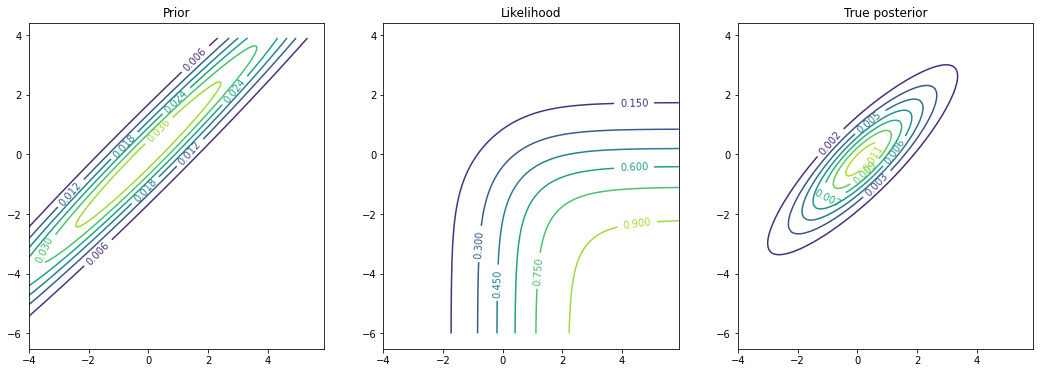

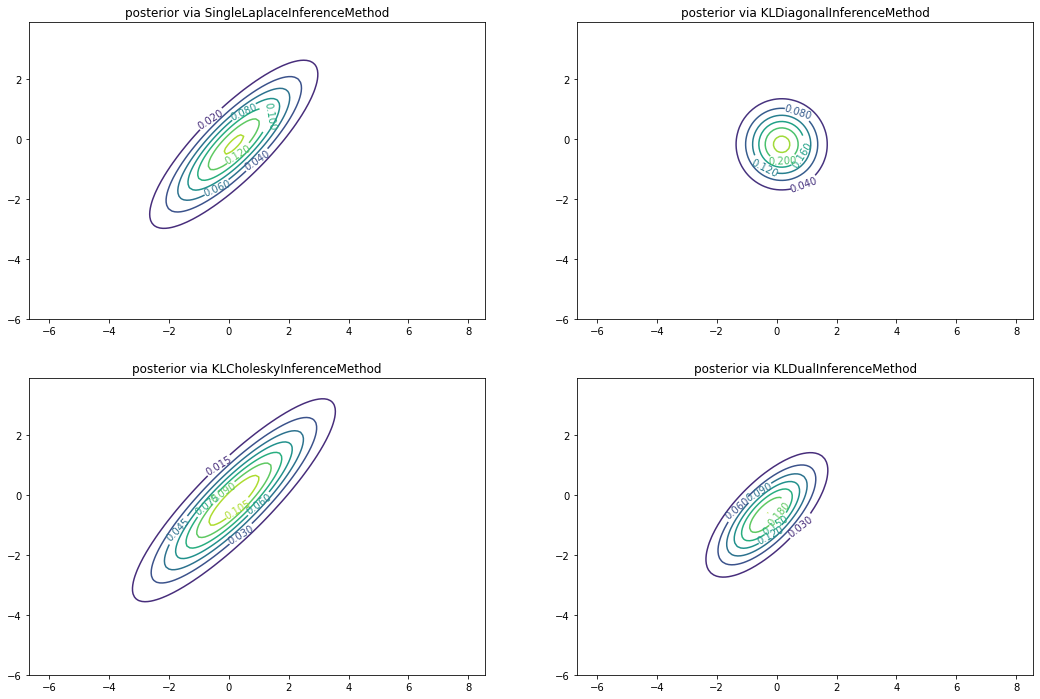

In [6]:
#a toy 2D example (data)
x=np.asarray([sqrt(2),-sqrt(2)]).reshape(1,2)
y=np.asarray([1,-1])

features = sg.create_features(x)
labels = sg.BinaryLabels(y)
kernel_log_sigma = 1.0
kernel_log_scale = 1.5

#a mean function and a covariance function for GP
mean_func = sg.create_gp_mean("ConstMean")
#using log_sigma as a hyper-parameter of GP instead of sigma
kernel_sigma = 2*exp(2*kernel_log_sigma)
kernel_func = sg.create_kernel("GaussianKernel", log_width=np.log(kernel_sigma))
kernel_func.init(features, features)
#a prior distribution derived from GP via applying the mean function and the covariance function to data
Sigma = kernel_func.get_kernel_matrix()
Sigma = Sigma * exp(2.0*kernel_log_scale)
mu = mean_func.get_mean_vector(features)

delta = 0.1
xmin = -4
xmax = 6
ymin = -6
ymax = 4

#a prior (Gaussian) derived from GP
(X,Y,Z1) = Gaussian_points(Sigma, mu, xmin, xmax, ymin, ymax, delta)

col_size = 6
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(col_size*3,col_size))

CS1=ax1.contour(X, Y, np.exp(Z1))
ax1.set_title('Prior')
ax1.axis('equal')

ax1.clabel(CS1,
           inline=1,
           fontsize=10)

#likelihood (inverse logit, A.K.A. Bernoulli-logistic)
#likelihoods classes for inference methods  (see the likelihood table)
likelihoods=[
    "LogitLikelihood",
    "LogitVGLikelihood",
    "LogitVGLikelihood",
    "LogitDVGLikelihood"
]
#likelihood
Z2 = likelihood_points(X,Y,labels,sg.create_gp_likelihood("LogitLikelihood"))
CS2 = ax2.contour(X, Y, np.exp(Z2))
ax2.set_title('Likelihood')
ax2.axis('equal')
ax2.clabel(CS2,
           inline=1,
           fontsize=10)

#a unnormalized true posterior (non-Gaussian)
Z3 = Z1+Z2
CS3 = ax3.contour(X, Y, np.exp(Z3))
ax3.set_title('True posterior')
ax3.axis('equal')
ax3.clabel(CS3,
           inline=1,
           fontsize=10)

f, plots =plt.subplots(2, 2, figsize=(col_size*3,col_size*2))

#Inference methods used to approximate a posterior (see the table below)
methods=[
    "SingleLaplaceInferenceMethod",
    "KLDiagonalInferenceMethod",
    "KLCholeskyInferenceMethod",
    "KLDualInferenceMethod"
]
#posterior
approx_posterior_plot(methods, kernel_func, features, mean_func, labels, likelihoods, kernel_log_scale, 
                      xmin, xmax, ymin, ymax, delta, plots)

plt.show()

Remark:
The true posterior is a non-Gaussian distribution and the normalized constant usually is difficult to compute.
All approximated posteriors are Gaussian distributions. A posterior Gaussian distribution can efficiently perform inference and predictions.
The Laplace approximation is not ideal in term of approximating a posterior and making predictions although it is fast.
With the price of speed, variational methods such as the KLCovariance and the KLCholesky offer more accurate approximations compared than the Laplace method. The KLDual method also can have a good approximation and in many cases are better than the Laplace method. On the other hand, the KLApproxDiagonal (mean-field) method is as fast as the Laplace method and for certain datasets, the KLApproxDiagonal method is more accurate than Laplace method in term of making predictions. 

## <a id='visu'>An Example for Visualization (banana dataset)</a> <a href='#toc'>[TOP]</a>

We use the banana data set to demonstrate decision boundary of GPC. The data set can be found at <a href="http://sci2s.ugr.es/keel/dataset.php?cod=182">here</a>. This is a binary classification problem. The goal of this example is to visually show the decision boundary of GPC models. The following is the description of the data set.

It is an artificial data set where instances belongs to several clusters with a banana shape. There are two attributes At1 and At2 corresponding to the x and y axis, respectively. The class label (-1 and 1) represents one of the two banana shapes in the dataset.

We now define code to train a GP classifier using Shogun.

In [7]:
def train_small_scale(inference: str, linesearch, likelihood, x_train, y_train, kernel_log_sigma, kernel_log_scale):
    
    """
    This function is used to train a GP classifer given an inference method
        
    Parameters:
        inference - an inference methods used to train the classifer
        linesearch - a linesearch method used in the inference method 
        likelihood - likelihood function to model data
        x_train, x_test - X for training and testing
        y_train - labels for training
        kernel_log_sigma, kernel_log_scale hyper-parameters of covariance function    
    Returns:
        trained GPC model, name of inference method
    """

    mean_func = sg.create_gp_mean("ZeroMean")
    kernel_sigma = 2*exp(2*kernel_log_sigma);
    kernel_func = sg.create_kernel("GaussianKernel", log_width=np.log(kernel_sigma))

    #Y is a sample-by-1 vector
    labels_train = sg.BinaryLabels(y_train)
    #X is a feature-by-sample matrix
    features_train=sg.create_features(x_train)

    inf = sg.create_gp_inference(inference, kernel=kernel_func, features=features_train, mean_function=mean_func, labels=labels_train, likelihood_model=likelihood)
    inf.set_scale(exp(kernel_log_scale))

    gp = sg.create_gaussian_process("GaussianProcessClassification", inference_method=inf)
    gp.train()

    return gp, inf.get_name()

In [8]:
def extract_banana_dataset(input_path):
    """
    This function is used to process raw data of the banana data set
        
    Parameters:
        inf - the path of the raw data
    Returns:
        x_train, x_test - features for training and testing
        y_train, y_test - labels for training and testing
        x1s, x2s  -for ploting training or testing points
    """

    random.seed(1)
    x=[[], []]
    y=[[], []]
    x1s=[{}, {}]
    x2s=[{}, {}]

    for line in open(input_path):
        line=line.strip()
        if line.startswith("@"):
            continue
        choice=random.randint(0,1)
        if choice==0:
            #testing set
            idx=1
        else:
            #training set
            idx=0
        info=list(map(float,line.split(',')))
        x[idx].append(info[:-1])
        y[idx].append(info[-1])
        if info[-1]>0:
            #positive cases
            container_x1=x1s[idx].setdefault(1,[])
            container_x2=x2s[idx].setdefault(1,[])
        else:
            #negative cases
            container_x1=x1s[idx].setdefault(0,[])
            container_x2=x2s[idx].setdefault(0,[])
        container_x1.append(info[0])
        container_x2.append(info[1])

    x_train = np.asarray(x[0]).T
    y_train = np.asarray(y[0])
    x_test = np.asarray(x[1]).T
    y_test = np.asarray(y[1])

    return x_train, y_train, x_test, y_test, x1s, x2s

In [9]:
from itertools import product
def plot_small_scale(input_path):
    """
    This function is used to print the decision bounday and testing points
        
    Parameters:
        inf - the path of the raw data
    """
    #obtain data points with labels from raw data
    (x_train, y_train, x_test, y_test, x1s, x2s)=extract_banana_dataset(input_path)
    
    #binary classification problem (positive labels and negative labels)
    inference = "SingleLaplaceInferenceMethod"
    likelihood = sg.create_gp_likelihood("LogitLikelihood")
    linesearch = 3
    
    #we show how parameters of GPC affect the decision boundary
    #over-fit, right-fit, under-fit
    kernel_log_sigmas=[-5,0,1]
    kernel_log_scale=0 #we fix the scale parameter
    
    #plot setting
    col_size=8
    f, plots =plt.subplots(len(kernel_log_sigmas),2,figsize=(col_size*2,col_size*len(kernel_log_sigmas)))
    
    #points used to generate decision boundary
    n_boundary=50
    x1_boundary = np.linspace(x_train[0,:].min()-1, x_train[0,:].max()+1, n_boundary)
    x2_boundary = np.linspace(x_train[1,:].min()-1, x_train[1,:].max()+1, n_boundary)
    x_boundary = np.asarray(list(product(x1_boundary, x2_boundary))).T

    features_boundary=sg.create_features(x_boundary)
    
    for idx,kernel_log_sigma in enumerate(kernel_log_sigmas):
        #train a GPC model given traning data points
        (gpc, name)=train_small_scale(inference, linesearch, likelihood, x_train, y_train, kernel_log_sigma, kernel_log_scale)
        #obtain the probabilities of being positive label(s) given new data point(s)
        prbs=gpc.get_probabilities(features_boundary)

        for choice in [0,1]:
             #decision boundary
             plots[idx][choice].contour(x1_boundary, x2_boundary, np.reshape(prbs, (n_boundary, n_boundary)).T, levels=[0.5], colors=('blue'))  
             #training points or testing points with true positive tag
             plots[idx][choice].scatter(x1s[choice][1],x2s[choice][1], c='red', alpha=0.5)
             #training points or testing points with true negative tag
             plots[idx][choice].scatter(x1s[choice][0],x2s[choice][0], c='yellow', alpha=0.5)
             plots[idx][choice].set_xlabel("At1")
             plots[idx][choice].set_ylabel("At2")
             plots[idx][choice].axis("equal")
             type_name="training"
             if choice==1:
                type_name="testing"
             if idx==0:
                fit_condition="over-fit"
             elif idx==1:
                fit_condition="right-fit"
             else:
                fit_condition="under-fit"                           
             plots[idx][choice].set_title("Decision boundary (blue) \n of %s on %s points (%s)"%(name, type_name,fit_condition))

    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: No contour levels were found within the data range.


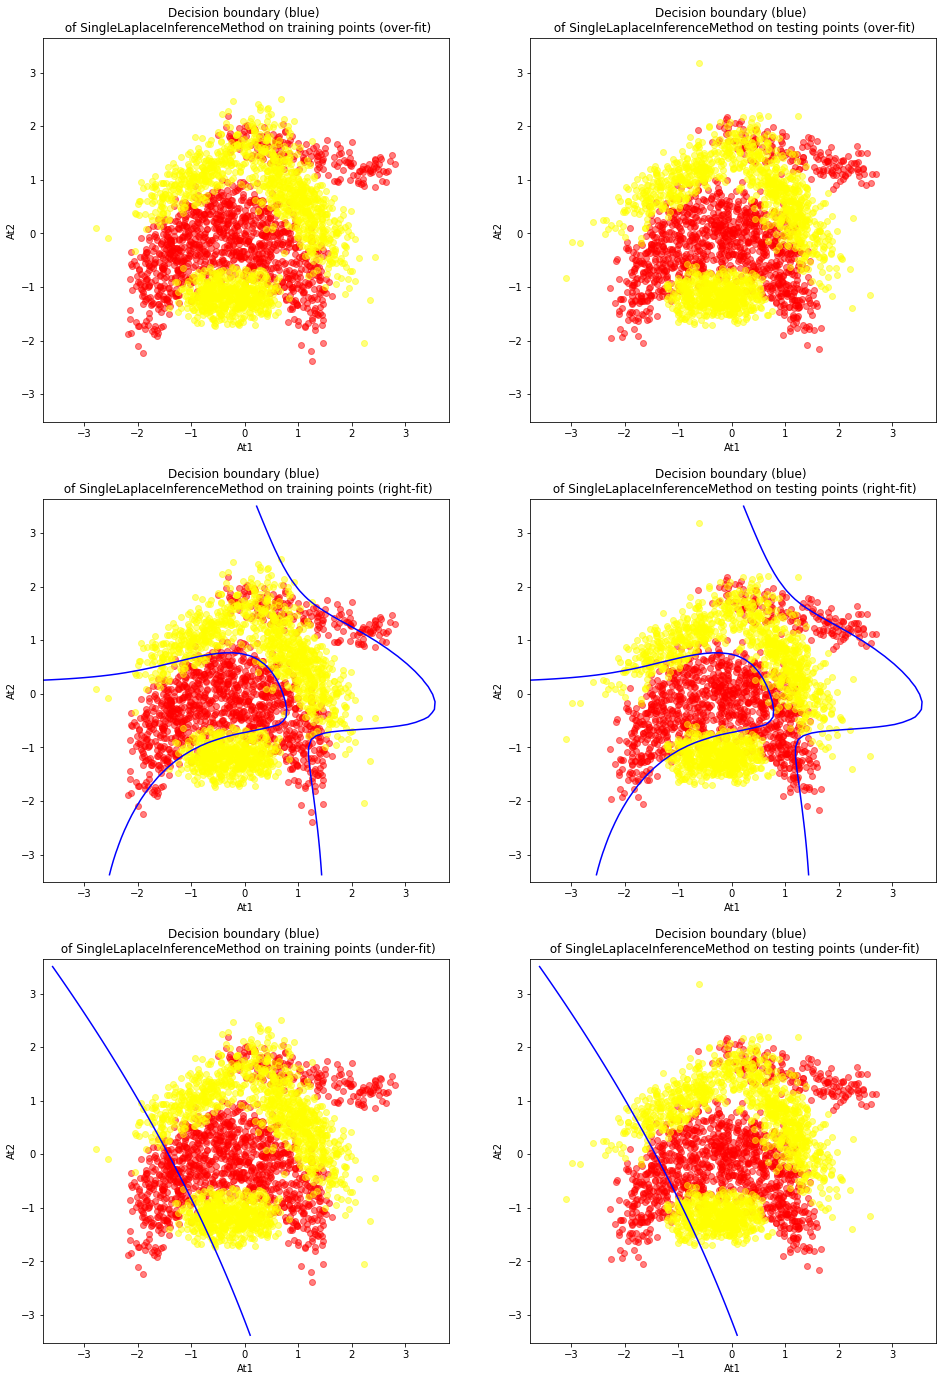

In [10]:
input_path=os.path.join(SHOGUN_DATA_DIR, 'toy/banana.dat')
plot_small_scale(input_path)

## <a id="largescale">A Glimpse of Large Scale Inference Methods</a> <a href='#toc'>[TOP]</a>

### <a id="difficulty">Difficulty of Scaling up Standard GPC Models</a> <a href='#toc'>[TOP]</a>

Readers may know that a GPC model is a <a href="http://en.wikipedia.org/wiki/Nonparametric_statistics#Non-parametric_models">non-parametric model</a>. Indeed, a  GPC model is memory based and dependent on training data and summarized through the approximated posterior distribution, $q(\mathbf{f}|\mathbf{y})$, (a Gaussian distribution for variational Gaussian inference). In variational Gaussian inference for a **standard** GPC model, we must store an amount of information that increases with the number of training data, $n$. Recall that in variational Gaussian inference, we need to store mean (n-by-1) vector, $\mu$, and covariance (n-by-n) matrix, $\Sigma$, of $q(\mathbf{f}|\mathbf{y})$. We need to perform matrix inversion (or matrix factorization) related to the covariance matrix in the training process. In general, the time complexity of such matrix inversion is O($n^3$)

### <a id="sparseGP">Big Picture of Sparse GPC Models for Large Scale Inference</a> <a href='#toc'>[TOP]</a>

The idea of <a href="http://www.jmlr.org/papers/v6/quinonero-candela05a.html">sparse GP models</a> is to approximate the covariance matrix of prior distribution, $p(\mathbf{f})$ with a <a href="http://en.wikipedia.org/wiki/Positive-definite_matrix">positive definite matrix</a> that can reduce the time complexity in the training phrase.

We pay attention to <a href="http://www.gatsby.ucl.ac.uk/~snelson/SPGP_up.pdf">the inducing point</a> approach, where a set of inducing data, $\mathbf{S}$, is used in the training process. We define $\mathbf{S}\in\mathcal{R}^{m\times d}$, where $m$ is the number of inducing points and $d$ is the number of features.  Under the assumption of <a href="http://papers.nips.cc/paper/3351-the-generalized-fitc-approximation.pdf">Fully Independent Training Conditional</a> (FITC), the inducing point approach uses a "diagonal plus low rank" matrix to approximate the covariance matrix of the prior distribution. In the inducing point approach with FITC assumption, we can reduce the time complexity related to the covariance matrix of $q(\mathbf{f}|\mathbf{y})$ in variational Gaussian inference from O($n^3$) to O($n\times m^2$) using the <a href="http://en.wikipedia.org/wiki/Binomial_inverse_theorem">Binomial Inverse Theorem</a>.
Note that $m \le n$, where $n$ is the number of training points. What is more, when $\mathbf{S}= \mathbf{X}$, the sparse GPC model becomes a standard GPC model.


We will cover more detail about large scale inference methods for GPC models in a new notebook.
Here, we present a list of large scale inference methods to be implemented in Shogun.

<table>
<tr>
<th>Large Scale Inference Methods based on Sparse GPC Models</th>
<th>Main idea</th>
</tr>
<tr>
<td>FITC Laplace Inference <a href="http://www.jmlr.org/papers/v6/quinonero-candela05a.html">[1]</a> <a href="http://papers.nips.cc/paper/3351-the-generalized-fitc-approximation.pdf">[2]</a> </td>
<td>Conditional independence related to inducing data points, Laplace approximation</td>
</tr>
<tr>
<td>Parallel/Distributed Variational Inference<a href="http://arxiv.org/abs/1402.1389">[1]</a>  <a href="http://arxiv.org/abs/1402.1412">[2]</a></td>
<td>Conditional independence related to inducing data points, Variational Gaussian inference
</td>
</tr>
<tr>
<td>Stochastic Variational Inference<a href="http://auai.org/uai2013/prints/papers/244.pdf">[1]</a> <a href="http://jmlr.org/proceedings/papers/v38/hensman15.pdf">[2]</a></td>
<td>Conditional independence related to inducing data points, Stochastic natural gradient, Variational Gaussian inference</td>
</tr>


<tr>
<td>Nonparametric Variational Inference<a href="http://machinelearning.wustl.edu/mlpapers/papers/ICML2012Gershman_360">[1]</a> <a href="http://papers.nips.cc/paper/5374-a-safe-screening-rule-for-sparse-logistic-regression">[2]</a></td>
<td>Conditional independence related to inducing data points, Nonparametric Variational inference ($q(\cdot)$ is Mixture of Gaussians)
</td>
</tr>

</table>


In [11]:
def train_large_scale(inference: str, linesearch, likelihood, x_train, y_train, x_inducing, kernel_log_sigma, kernel_log_scale, optimizing_inducing_points):
    
    """
    This function is used to train a GP classifer given an inference method
        
    Parameters:
        inference - an inference methods used to train the classifer
        linesearch - a linesearch method used in the inference method 
        likelihood - likelihood function to model data
        x_train, x_test - features for training and testing
        y_train - labels for training
        kernel_log_sigma, kernel_log_scale hyper-parameters of covariance function    
        optimizing_inducing_features - whether we optimize inducing features
    Returns:
        trained GPC model, name of inference method
    """

    mean_func = sg.create_gp_mean("ZeroMean")
    kernel_sigma = exp(kernel_log_sigma);
    kernel_func = sg.create_kernel("GaussianARDSparseKernel")
    kernel_func.put("log_weights", np.full((1), 1.0/kernel_sigma))
    

    #Y is a sample-by-1 vector
    labels_train = sg.BinaryLabels(y_train)
    #X is a feature-by-sample matrix
    features_train=sg.create_features(x_train)
    features_inducing=sg.create_features(x_inducing)
    inf = sg.create_gp_inference(inference, kernel=kernel_func, features=features_train, mean_function=mean_func, labels=labels_train, likelihood_model=likelihood, inducing_features=features_inducing)
    inf.set_scale(exp(kernel_log_scale))
    #if optimizing_inducing_points:
        ##inf.enable_optimizing_inducing_features(True, sg.LBFGSMinimizer())
        #inf.set_tolearance_for_inducing_features(1e-3)
        #inf.set_max_iterations_for_inducing_features(20)
   # try:
        #setting parameters for inducing points
       # inf.set_inducing_noise(1e-6);
    #except:
        #pass
    gp = sg.create_gaussian_process("GaussianProcessClassification", inference_method=inf)
    gp.train()
    return gp, inf

In [12]:
def plot_helper(plots,x1_boundary,x2_boundary,x_prbs,n_boundary,name,x1s,x2s,info=""):   
    """
    This helper function is used for plot decision boundary
        
    Parameters:
        plots - a list of plots
        x1_boundary, x2_boundary -features of boundary points used for determining decision boundary
        x_prbs -probabilities of being positive labels of the boundary points
        n_boundary -number of boundary points
        name -name of inference method
        x1s, x2s - training and testing points (different from boundary points)
        info - string used in plot titles
    """
        
    for choice in [0,1]:
        #decision boundary
        plots[choice].contour(x1_boundary, x2_boundary, np.reshape(x_prbs, (n_boundary, n_boundary)).T, levels=[0.5], colors=('blue')) 
       
        
        #training points or testing points with true positive tag
        plots[choice].scatter(x1s[choice][1],x2s[choice][1], c='red', alpha=0.5)
        #training points or testing points with true negative tag
        plots[choice].scatter(x1s[choice][0],x2s[choice][0], c='yellow', alpha=0.5)
        plots[choice].set_xlabel("At1")
        plots[choice].set_ylabel("At2")
        plots[choice].axis("equal")
        type_name="training"
        if choice==1:
            type_name="testing"                         
        plots[choice].set_title("Decision boundary (blue) \n of %s\n%s on %s points"%(name, info, type_name))

In [13]:
from itertools import product
def plot_large_scale(input_path):
    """
    This function is used to plot the decision bounday and training and testing points
        
    Parameters:
        input_path - the path of the raw data
    """
    #obtain data points with labels
    (x_train, y_train, x_test, y_test, x1s, x2s)=extract_banana_dataset(input_path)
    print("%d training points"%(len(x_train[0])))
    #we want to compare two inference methods
    inferences =[
                    "SingleFITCLaplaceInferenceMethod", #inference method for sparse Gaussian processes
                    "SingleLaplaceInferenceMethod",    #inference method for full Gaussian processes
                ]
    likelihood = sg.create_gp_likelihood("LogitLikelihood")
    linesearch = 3
    kernel_log_sigma=0
    kernel_log_scale=0
    
    #plot setting
    col_size=8
    f, plots =plt.subplots(2,2,figsize=(col_size*2,col_size*2))
    
    #generating boundary points
    #these boundary points are used to generate decision boundaries
    n_boundary=20
    x1_boundary =np.linspace(x_train[0,:].min(), x_train[0,:].max(), n_boundary)
    x2_boundary =np.linspace(x_train[1,:].min(), x_train[1,:].max(), n_boundary)
    x_boundary = np.asarray(list(product(x1_boundary, x2_boundary))).T

    features_boundary=sg.create_features(x_boundary)

    #generate inducing points for sparse Gaussian process models
    #note that we use a few inducing points instead of all training points
    n_inducing=20  
    x1_inducing = np.random.rand(n_inducing)*(x_train[0,:].max()-x_train[0,:].min())+x_train[0,:].min()
    x2_inducing = np.random.rand(n_inducing)*(x_train[1,:].max()-x_train[1,:].min())+x_train[1,:].min()
    x_inducing=np.row_stack([x1_inducing,x2_inducing])
    print("%d inducing points"%(n_inducing))
    #for measuring runtime
    import time
    start=time.time()
    #FITC Laplace approximation (inference method for sparse Gaussian processes)
    (gpc, inf)=train_large_scale(inferences[0], linesearch, likelihood, x_train, y_train, x_inducing, kernel_log_sigma, kernel_log_scale, False)
    name=inf.get_name()
    prbs=gpc.get_probabilities(features_boundary)
    print("FITC Laplace inference took %.2f seconds" % (time.time()-start))
    plot_helper(plots[0],x1_boundary,x2_boundary,prbs,n_boundary,name,x1s,x2s,"with %d unoptimized inducing points"%n_inducing)
    
    #plot the inducing points used in sparse Gaussian process models
    plots[0][0].scatter(x1_inducing, x2_inducing, marker=(5,1), c='green',s=60)
    plots[0][1].scatter(x1_inducing, x2_inducing, marker=(5,1), c='green',s=60)
    
    plots[0][0].legend(["positive points","negative points", "inducing points"],scatterpoints=1)
    plots[0][1].legend(["positive points","negative points", "inducing points"],scatterpoints=1)
    
    start=time.time()
    #Laplace approximation (inference method for full Gaussian processes)
    (gpc, name)=train_small_scale(inferences[1], linesearch, likelihood, x_train, y_train, kernel_log_sigma, kernel_log_scale)
    prbs=gpc.get_probabilities(features_boundary)
    print("Laplace inference took %.2f seconds" % (time.time()-start))
    plot_helper(plots[1],x1_boundary,x2_boundary,prbs,n_boundary,name,x1s,x2s)

    plots[1][0].legend(["positive points","negative points"],scatterpoints=1)
    plots[1][1].legend(["positive points","negative points"],scatterpoints=1)

2688 training points
20 inducing points
FITC Laplace inference took 0.16 seconds
Laplace inference took 10.69 seconds


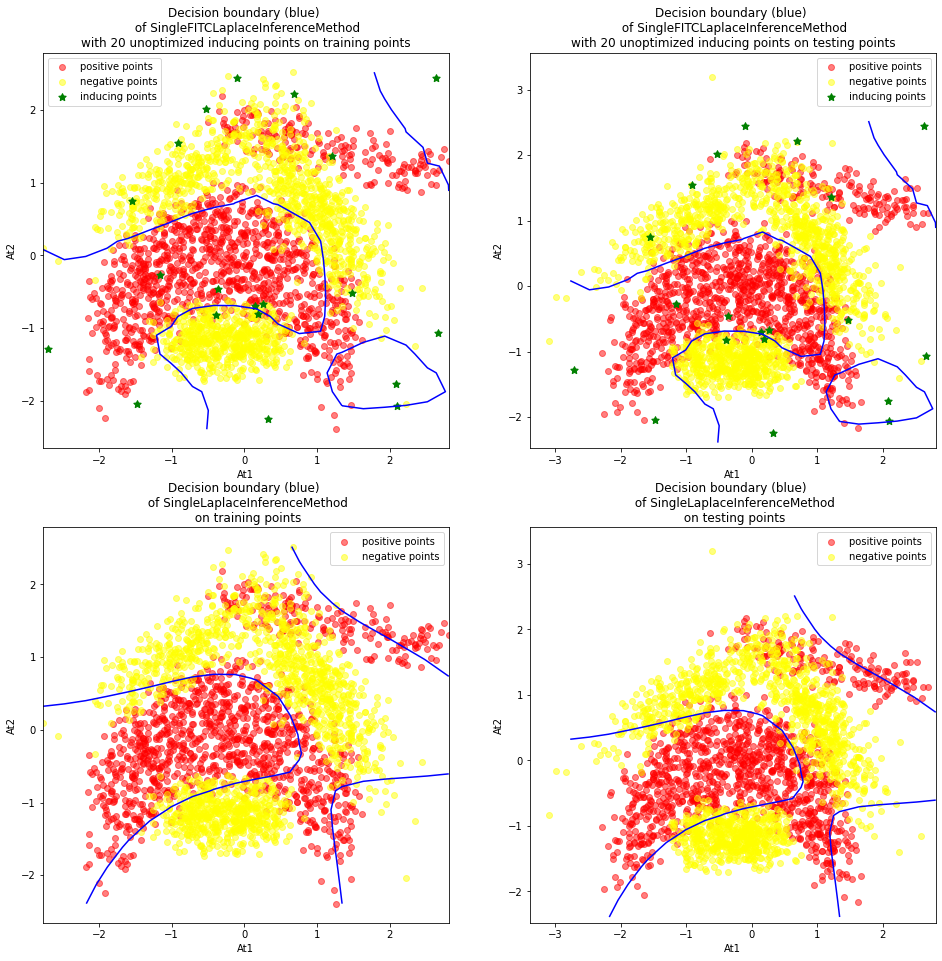

In [14]:
#Since inducing points are generated by random, decision boundary of SingleFITCLaplace could be different if random seed is different
np.random.seed(8) 
input_path=os.path.join(SHOGUN_DATA_DIR, 'toy/banana.dat')
plot_large_scale(input_path)

Remark: SingleFITCLaplacian is the implementation of the FITC Laplace inference method in Shogun. We can make the following observations:
* FITC Laplace inference method improves the efficiency in the training phrase.
* The loss of accuracy in prediction may be acceptable given the huge improvement in time.
* Good inducing points plays a significant role in accuracy.
* Selecting reasonable inducing points may be not trivial.

Indeed, inducing points can be a subset of training points or can be obtained from optimizing some criterion (eg, marginal approximated log likelihood). We will cover this in the following section.

### <a id="optInd">Optimizing Inducing Points</a> <a href='#toc'>[TOP]</a>

In [15]:
def plot_large_scale_with_inducing_points(input_path,n_inducing):
    """
    This function is used to plot the decision bounday and training and testing points
        
    Parameters:
        input_path - the path of the raw data
        n_inducing - number of inducing points
    """
    #obtain data points with labels
    (x_train, y_train, x_test, y_test, x1s, x2s)=extract_banana_dataset(input_path)
    print("%d training points"%(len(x_train[0])))
    #we want to compare two inference methods
    inferences =[
               "SingleFITCLaplaceInferenceMethod", #inference method for sparse Gaussian processes
                ]
    likelihood = sg.create_gp_likelihood("LogitLikelihood")
    linesearch = 3
    kernel_log_sigma=0
    kernel_log_scale=0
    
    #plot setting
    col_size=8
    f, plots =plt.subplots(2,2,figsize=(col_size*2,col_size*2))
    
    #generating boundary points
    #these boundary points are used to generate decision boundaries
    n_boundary=20
    x1_boundary =np.linspace(x_train[0,:].min(), x_train[0,:].max(), n_boundary)
    x2_boundary =np.linspace(x_train[1,:].min(), x_train[1,:].max(), n_boundary)
    x_boundary = np.asarray(list(product(x1_boundary, x2_boundary))).T

    features_boundary=sg.create_features(x_boundary)

    #generate inducing points for sparse Gaussian process models
    #note that we use a few inducing points instead of all training points
    x1_inducing = np.random.rand(n_inducing)*(x_train[0,:].max()-x_train[0,:].min())+x_train[0,:].min()
    x2_inducing = np.random.rand(n_inducing)*(x_train[1,:].max()-x_train[1,:].min())+x_train[1,:].min()
    x_inducing=np.row_stack([x1_inducing,x2_inducing])
    print("%d inducing points"%(n_inducing))

    #FITC Laplace approximation (inference method for sparse Gaussian processes)
    (gpc, inf)=train_large_scale(inferences[0], linesearch, likelihood, x_train, y_train, x_inducing, kernel_log_sigma, kernel_log_scale, False)
    name=inf.get_name()
    prbs=gpc.get_probabilities(features_boundary)
    plot_helper(plots[0],x1_boundary,x2_boundary,prbs,n_boundary,name,x1s,x2s,"without optimizing %d inducing points"%n_inducing) 
    #x_inducing=inf.get_inducing_features().get("feature_matrix")  


    #plot the inducing points used in sparse Gaussian process models without optimizing inducing points
    #plots[0][0].scatter(x_inducing[0], x_inducing[1], marker=(5,1), c='green',s=60)
   # plots[0][1].scatter(x_inducing[0], x_inducing[1], marker=(5,1), c='green',s=60)
    
    plots[0][0].legend(["positive points","negative points", "raw inducing points"],scatterpoints=1)
    plots[0][1].legend(["positive points","negative points", "raw inducing points"],scatterpoints=1)
    
    
    #plot the inducing points used in sparse Gaussian process models with optimizing inducing points
    (gpc, inf)=train_large_scale(inferences[0], linesearch, likelihood, x_train, y_train, x_inducing, kernel_log_sigma, kernel_log_scale, True)
    name=inf.get_name()
    prbs=gpc.get_probabilities(features_boundary)
    plot_helper(plots[1],x1_boundary,x2_boundary,prbs,n_boundary,name,x1s,x2s, "with optimized %d inducing points"%n_inducing)
   # x_inducing=inf.get_inducing_features().get("feature_matrix")  
    
    #plots[1][0].scatter(x_inducing[0], x_inducing[1], marker=(5,1), c='green',s=60)
    #plots[1][1].scatter(x_inducing[0], x_inducing[1], marker=(5,1), c='green',s=60)
    
    plots[1][0].legend(["positive points","negative points", "optimized inducing points"],scatterpoints=1)
    plots[1][1].legend(["positive points","negative points", "optimized inducing points"],scatterpoints=1)

2688 training points
8 inducing points


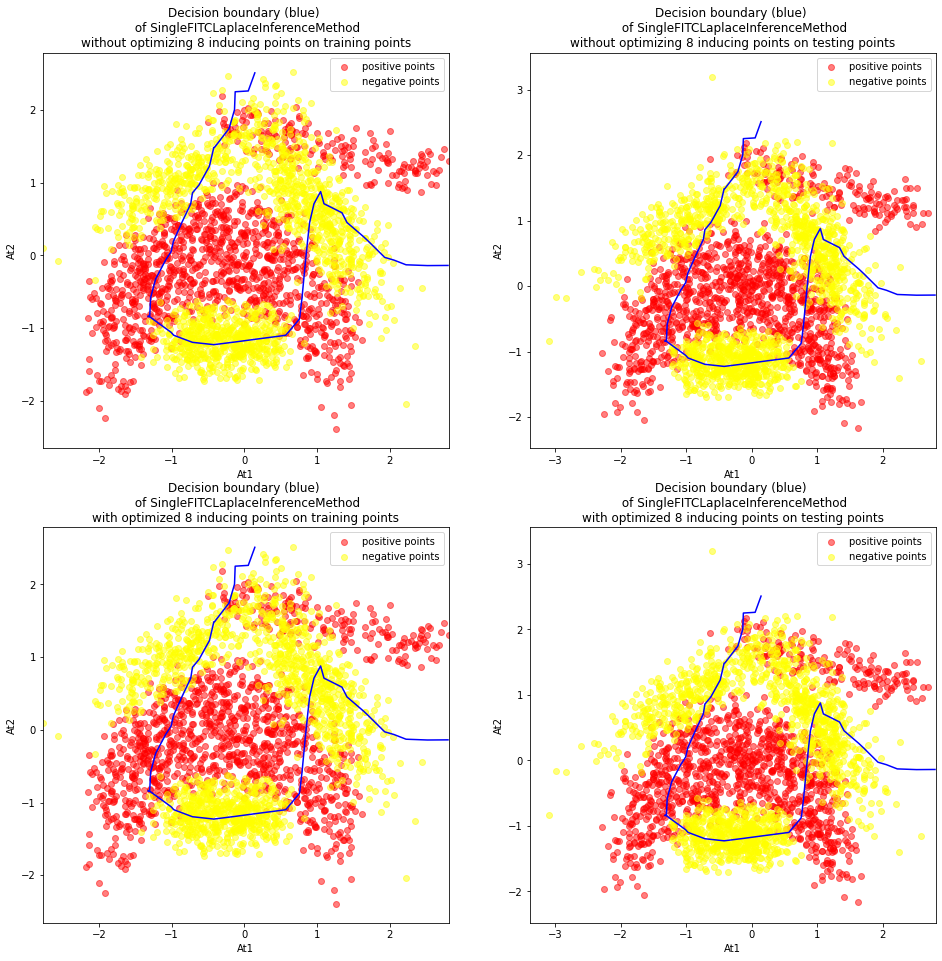

In [16]:
#Since inducing points are generated by random, decision boundary of SingleFITCLaplace could be different if random seed is different
np.random.seed(3) 
input_path=os.path.join(SHOGUN_DATA_DIR, 'toy/banana.dat')
n_inducing_points=8
plot_large_scale_with_inducing_points(input_path,n_inducing_points)

## <a id="realeg1">A Real-World Example (sonar dataset)</a> <a href='#toc'>[TOP]</a>

We train GP classifiers for the sonar data set. The data set can be found at <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/">here</a>. This is a binary classification problem. The goal of this example is to compare all inference methods of full Gaussian processes implemented in shogun in term of making prediction predictions. This example is about reproducing the example at page 29 of the paper, <a href="http://www.jmlr.org/papers/volume9/nickisch08a/nickisch08a.pdf">Approximations for binary Gaussian process classification</a>. Please refer the paper about the definition of the information bit measure. The following is the description of the data set.

The class "sonar.mines" contains 111 data points  obtained by bouncing sonar
signals off a metal cylinder at various angles and under various
conditions.  The class "sonar.rocks" contains 97 data points obtained from
rocks under similar conditions.  The transmitted sonar signal is a
frequency-modulated chirp, rising in frequency.  The data set contains
signals obtained from a variety of different aspect angles, spanning 90
degrees for the cylinder and 180 degrees for the rock.
Each data point is a set of 60 features in the range 0.0 to 1.0.  Each feature
represents the energy within a particular frequency band, integrated over
a certain period of time.  The integration aperture for higher frequencies
occur later in time, since these frequencies are transmitted later during
the chirp.
The label associated with each record contains the letter "R" if the object
is a rock and "M" if it is a mine (metal cylinder).  The features in the
labels are in increasing order of aspect angle, but they do not encode the
angle directly.

In [17]:
def learning_example1(inference: str, minimizer, linesearch, likelihood, x_train, y_train, x_test, y_test, kernel_log_sigma, kernel_log_scale):
    
    """
    This function is used to train a GP classifer given an inference method
        
    Parameters:
        inference - an inference methods used to train the classifer
        minimizer - minimizer used in inference
        linesearch - line search used in minimizer
        likelihood - likelihood function to model data
        x_train, x_test - X for training and testing
        y_train, y_test - Y for training and testing
        kernel_log_sigma, kernel_log_scale hyper-parameters of covariance function    
    Returns:
        predictive result of the testing data set, name of inference method
    """

    mean_func = sg.create_gp_mean("ZeroMean")
    kernel_sigma = 2*exp(2*kernel_log_sigma);
    kernel_func = sg.create_kernel("GaussianKernel", log_width=np.log(kernel_sigma))

    #Y is a sample-by-1 vector
    labels_train = sg.BinaryLabels(y_train)
    labels_test = sg.BinaryLabels(y_test)
    #X is a feature-by-sample matrix
    features_train=sg.create_features(x_train)
    features_test=sg.create_features(x_test)

    inf = sg.create_gp_inference(inference, kernel=kernel_func, features=features_train, mean_function=mean_func, labels=labels_train, likelihood_model=likelihood)
    inf.set_scale(exp(kernel_log_scale))
    try:
    #used to make sure the kernel matrix is positive definite
        inf.set_noise_factor(1e-6)
        inf.set_min_coeff_kernel(1e-5)
        inf.set_max_attempt(10)
    except:
        pass
    if minimizer !=None:
        opt=minimizer()
        opt.set_lbfgs_parameters(100,2000,linesearch,2000)
        inf.register_minimizer(opt);

    gp = sg.create_gaussian_process("GaussianProcessClassification", inference_method=inf)
    gp.train()
    prob=gp.get_probabilities(features_test)

    return prob, inf.get_name()

In [18]:
labels={
    "m":1,
    "r":-1,
       }

def extract(inf, train_size):
    """
    This function is used to processing raw data
        
    Parameters:
        inf - the path of the raw data
        train_size - number of data points used for testing   
        
    Returns:
        x_train, x_test - X for training and testing
        y_train, y_test - Y for training and testing
        B - for computing the information bit
    """

    random.seed(1)
    x=[]
    y=[]
    for line in open(inf):
        line=line.strip()
        info=line.split(',')
        label=labels[info[-1].lower()]
        x.append(list(map(float, info[:-1])))
        y.append(label)
        
    #train_size should be less than the size of all available data points
    assert train_size < len(x) 
    idx=[i for i in range(len(y))]
    random.shuffle(idx)
    train_idx=set(idx[:train_size])
    test_idx=set(idx[train_size:])
    x_train = np.asarray([value for (idx, value) in enumerate(x) if idx in train_idx]).T
    y_train = np.asarray([label for (idx, label) in enumerate(y) if idx in train_idx])
    x_test = np.asarray([value for (idx, value) in enumerate(x) if idx in test_idx]).T
    y_test = np.asarray([label for (idx, label) in enumerate(y) if idx in test_idx])

    y_train_positive=(y_train==1).sum()
    y_train_negative=(y_train==-1).sum()
    y_test_positive=(y_test==1).sum()
    y_test_negative=(y_test==-1).sum()

    prb_positive=float(y_train_positive)/len(y_train)
    B=float(y_test_positive)*log(prb_positive,2)+float(y_test_negative)*log(1.0-prb_positive,2)
    B=-B/len(y_test)

    return x_train, y_train, x_test, y_test, B

In [19]:
def approx_bit_plot(methods: List[str], minimizers, linesearches, likelihoods: List[str], x_train, y_train, x_test , y_test, plots, lScale, lSigma, B):
    """
    This function is used to plot information bit figures
        
    Parameters:
        methods - a list of inference methods used to train the classifer
        minimizers - a list of minimizers used in the inference method
        linesearches - a list of line search methods used in minimizer
        likelihood - a list of likelihood functions to model data
        x_train, x_test - X for training and testing
        y_train, y_test - Y for training and testing
        plots  - plot objects
        lScale, lSigma  - a list of hyper-parameters of covariance function    
        B - for computing information bits
        
    Returns:
        predictive result of the testing data set
    """
    #Note that information bit is used to measure effectiveness of an inference method
    if len(plots.shape)==1:
        rows=1
        cols=plots.shape[0]
    else:
        (rows, cols) = plots.shape

    methods=np.asarray(methods).reshape(rows, cols)
    minimizers=np.asarray(minimizers).reshape(rows, cols)
    linesearches=np.asarray(linesearches).reshape(rows, cols)
    likelihoods=np.asarray(likelihoods).reshape(rows, cols) 

    for r in range(rows):
        for c in range(cols):
            inference = methods[r][c]
            minimizer = minimizers[r][c]
            likelihood_name = likelihoods[r][c]
            linesearch = linesearches[r][c]
            likelihood = sg.create_gp_likelihood(likelihood_name)
            try:
                likelihood.set_noise_factor(1e-15)
                likelihood.set_strict_scale(0.01)
            except:
                pass
            scores=[]
            for items in zip(lScale, lSigma):
                for parameters in zip(items[0],items[1]):
                    lscale=parameters[0]
                    lsigma=parameters[1]
                    (prob, inf_name)=learning_example1(inference, minimizer, linesearch, likelihood, x_train, y_train, x_test,  y_test, 
                                              lscale, lsigma)
                    #compute the information bit
                    score=0.0
                    for (label_idx, prb_idx) in zip(y_test, prob):
                        if label_idx==1:
                            score+=(1.0+label_idx)*log(prb_idx,2)
                        else: #label_idx==-1:
                            score+=(1.0-label_idx)*log(1.0-prb_idx,2)
                    score=score/(2.0*len(y_test))+B
                    scores.append(score)
            scores=np.asarray(scores).reshape(int(len(lScale)),int(len(scores)/len(lScale)))

            if len(plots.shape)==1:
                sub_plot=plots
            else:
                sub_plot=plots[r]
            CS =sub_plot[c].contour(lScale, lSigma, scores)
            sub_plot[c].clabel(CS, inline=1, fontsize=10)
            sub_plot[c].set_title('information bit for %s'%inf_name)
            sub_plot[c].set_xlabel('log_scale')
            sub_plot[c].set_ylabel('log_sigma')
            sub_plot[c].axis('equal')

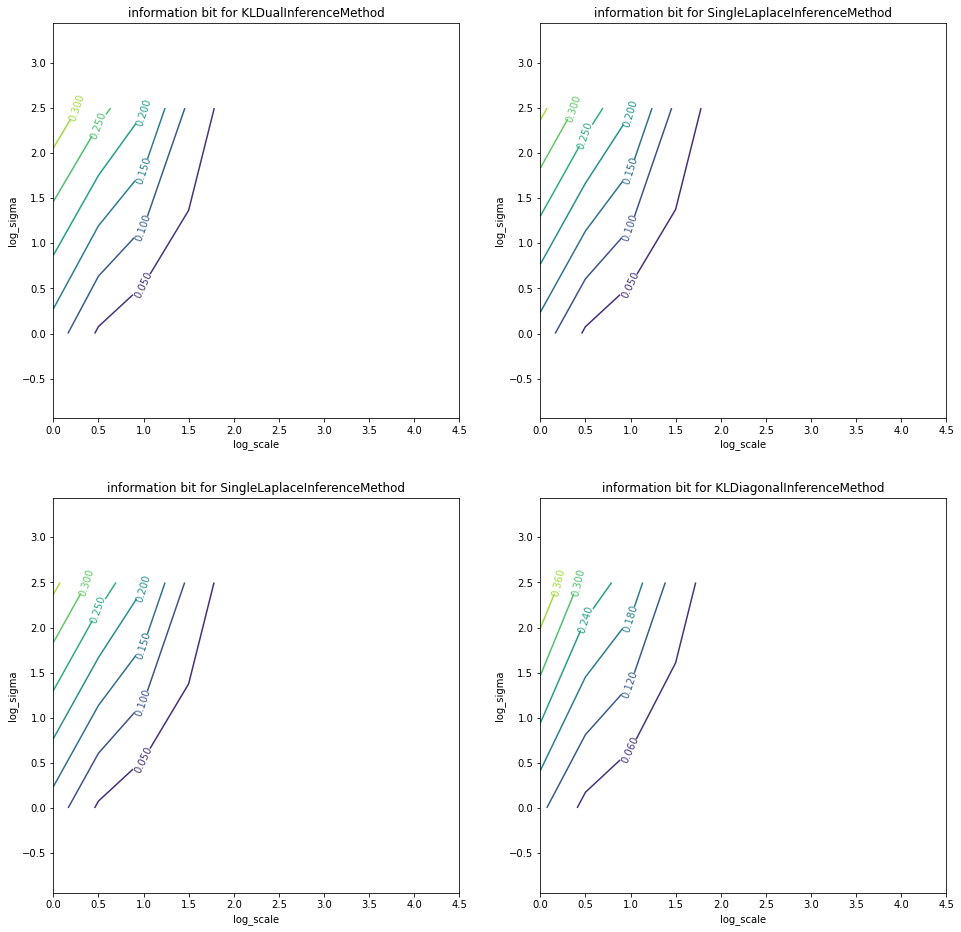

In [20]:
#an example for the sonar data set
train_size=108
(x_train, y_train, x_test, y_test, B)=extract(os.path.join(SHOGUN_DATA_DIR, 'uci/sonar/sonar.all-data'), train_size)
inference_methods =[
                  "KLDualInferenceMethod",
                  "SingleLaplaceInferenceMethod",
                  "SingleLaplaceInferenceMethod",
                  "KLDiagonalInferenceMethod",
                  #KLCholeskyInferenceMethod, #this method takes too long to run
                  #KLCovarianceInferenceMethod, #this method takes too long to run
                  ]

likelihoods =[
            "LogitDVGLikelihood", #KLDual method uses a likelihood class that supports dual variational inference
            "LogitLikelihood",        
            "LogitVGLikelihood", #KL method uses a likelihood class that supports variational inference
            "LogitVGLikelihood" #KL method uses a likelihood class that supports variational inference
            #LogitVGLikelihood(), #KL method uses a likelihood class that supports variational inference
            #LogitVGLikelihood(), #KL method uses a likelihood class that supports variational inference
            ]

minimizers =[
            sg.KLDualInferenceMethodMinimizer,
            None, #using default minimizer
            sg.LBFGSMinimizer,
            sg.LBFGSMinimizer,
            #LBFGSMinimizer,
            #LBFGSMinimizer,
            ]

linesearches=[
            sg.BACKTRACKING_ARMIJO,
            None, #using default line search method
            sg.BACKTRACKING_STRONG_WOLFE,
            sg.BACKTRACKING_STRONG_WOLFE,
            #BACKTRACKING_STRONG_WOLFE,
            #BACKTRACKING_STRONG_WOLFE,
            ]

col_size=8
lscale_min=0.0
lscale_max=5.0
lsigma_min=0.0
lsigma_max=5.0
delta=0.5
scale=5.0

lscale_list = np.arange(lscale_min, lscale_max, delta)
lsigma_list = np.arange(lsigma_min, lsigma_max, delta*scale)
lScale, lSigma = np.meshgrid(lscale_list, lsigma_list)
width=int(len(likelihoods)/2)
f, plots =plt.subplots(width, 2, figsize=(col_size*2,col_size*width))

approx_bit_plot(inference_methods, minimizers, linesearches, likelihoods, x_train, y_train,  x_test, y_test, plots, lScale, lSigma, B)

plt.show()

Note that the information bit is used to measure the accuracy of classification. 
If there is a perfect classification, the information bit should be 1. 
From these figures, we can observe that the Laplace method is worst among these methods in term of information bit. The EP method, the KLCholesky method and the KLCovariance method seem to be equally good. Surprisingly, for this data set, the KLApproxDiagonal method looks as good as the EP method in term of information bit. Note that in the KLApproxDiagonal method non-diagonal entries of the posterior covariance matrix are all zeros.  

## <a id="realeg2">Another Real-world Example (USPS dataset)</a> <a href='#toc'>[TOP]</a>

We use the US Postal Service (USPS) database of handwritten digits as another example. The dataset refers to numeric data obtained from the scanning of handwritten digits from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images.

We consider to classify the images of digit 3 from images of digit 5 as demonstration, which means only images of digit 3 and digit 5 are used. Note that this is example is also used in section 3.7.3 of the textbook, <a href="http://www.gaussianprocess.org/gpml/">Gaussian Processes for Machine Learning</a>.

In [6]:
def binary_extract(idx, features, labels):
    """
    This function is used to extract a trainning set and a test set
    
    Parameters:
        idx - a 2-wide list of digits (eg, [0,3] means to extract a sub set of images and labels for digit 3 and digit 0) 
        features - the whole image set 
        labels - the whole label set
        
    Returns:
        binary_features - X (images for binary classification)
        binary_labels - y (labels for binary classification)
    """
    #binary classification
    assert len(idx) == 2
    positive_idx = (labels[idx[0],:] == 1)
    negative_idx = (labels[idx[1],:] == 1)
    binary_idx = (positive_idx | negative_idx)
    ds = binary_idx.shape[-1]

    bin_labels = np.zeros(ds) 
    bin_labels[positive_idx] = 1
    bin_labels[negative_idx] = -1

    binary_features = (features[:,binary_idx])
    binary_labels = (bin_labels[binary_idx])
 
    positive_count = bin_labels[positive_idx].shape[-1]
    negative_count = bin_labels[negative_idx].shape[-1]
    binary_count = binary_labels.shape[-1]
 
    print("There are %d positive samples and %d negative samples" %(positive_count, negative_count))
    return binary_features, binary_labels

In [3]:
def learning_example2(inference: str, likelihood, x_train, x_test, y_train, y_test, using_lbfgs=False):
    """
    This function is used to train a GP classifer given an inference method
        
    Parameters:
        inference - an inference methods used to train the classifer
        likelihood - likelihood function to model data
        x_train, x_test - X for training and testing
        y_train, y_test - Y for training and testing 
        
    Returns:
        Nothing
    """
        
    #train a GP classifer
    error_eval = sg.create_evaluation("ErrorRateMeasure")
    mean_func = sg.create_gp_mean("ConstMean")
    #set hyper-parameters of covariance function
    kernel_log_sigma = 1.0
    kernel_sigma = 2*exp(2*kernel_log_sigma);
    kernel_func = sg.create_kernel("GaussianKernel", log_width=np.log(kernel_sigma))

    #sample by 1
    labels_train = sg.BinaryLabels(y_train)
    labels_test = sg.BinaryLabels(y_test)
    #feature by sample
    features_train=sg.create_features(x_train)
    features_test=sg.create_features(x_test)

    kernel_log_scale = 1.0

    inf = sg.create_gp_inference(inference, kernel=kernel_func, features=features_train, mean_function=mean_func, labels=labels_train, likelihood_model=likelihood)
    print("\nusing %s"%inf.get_name())
    
    inf.set_scale(exp(kernel_log_scale))
    
    if using_lbfgs:
        minimizer1 = sg.LBFGSMinimizer()
        minimizer1.set_lbfgs_parameters(100,80,sg.BACKTRACKING_STRONG_WOLFE,80)
        inf.register_minimizer(minimizer1);
    

    start = time.time()
    gp = sg.create_gaussian_process("GaussianProcessClassification", inference_method=inf)
    gp.train()
    end = time.time()
    print("cost %.2f seconds at training"%(end-start))
    nlz=inf.get_negative_log_marginal_likelihood()
    print("the negative_log_marginal_likelihood is %.4f"%nlz)
    start = time.time()
    #classification on train_data
    pred_labels_train = gp.apply_binary(features_train)
    #classification on test_data
    pred_labels_test = gp.apply_binary(features_test)
    end = time.time()    
    print("cost %.2f seconds at prediction"%(end-start))
    
    error_train = error_eval.evaluate(pred_labels_train, labels_train)
    error_test = error_eval.evaluate(pred_labels_test, labels_test)
    
    print("Train error : %.2f Test error: %.2f\n" % (error_train, error_test))

In [7]:
#an example for the USPS data set
data=scipy.io.loadmat(os.path.join(SHOGUN_DATA_DIR, 'toy/usps/usps_resampled/usps_resampled.mat'))
train_labels=data['train_labels']
test_labels=data['test_labels']
train_features=data['train_patterns']
test_features=data['test_patterns']
#using images of digit 3 and digit 5 from the dataset
idx=[3,5]
#Note that 
#y_train and y_test are followed the definition in the first section
#the transpose of x_train and x_test are followed the definition in the first section
print("Training set statistics")
(x_train, y_train)=binary_extract(idx,train_features, train_labels)
print("Test set statistics")
(x_test, y_test)=binary_extract(idx,test_features, test_labels)

Training set statistics
There are 406 positive samples and 361 negative samples
Test set statistics
There are 418 positive samples and 355 negative samples


### <a id='laplace'>Using Laplace Method</a> <a href='#toc'>[TOP]</a>

<a href="http://en.wikipedia.org/wiki/Laplace%27s_method">The Laplace method</a> can be viewed as a special case of variational method.
The idea of the Laplace method is to use the second-order <a href="http://en.wikipedia.org/wiki/Taylor_series">Taylor  expansion</a> in the <a href="http://en.wikipedia.org/wiki/Mode_%28statistics%29">mode</a>, $\mathbf{\hat{f}}$ of $p(\mathbf{f}|\mathbf{y})$ to approximate $p(\mathbf{f}|\mathbf{y})$, which is given below:

$p(\mathbf{f}|\mathbf{y}) \approx \hat{p}(\mathbf{f}|\mathbf{y})$ is $N(\mathbf{\hat{f}}, H_{\mathbf{\hat{f}}}^{-1})$ ,where $H_{\mathbf{\hat{f}}}$ is the <a href="http://en.wikipedia.org/wiki/Hessian_matrix">Hessian matrix</a> in $\mathbf{\hat{f}}$

Therefore, the KL divergence, ${\mathrm{KL}}(Q\|P)$, is approximated by $\int_{-\infty}^\infty \ln\left(\frac{q(\mathbf{f}|\mathbf{y})}{\hat{p}(\mathbf{f}|y)}\right) q(\mathbf{f}|\mathbf{y}) \ {\rm d}\mathbf{f}$.

By **minimizing** $\int_{-\infty}^\infty \ln\left(\frac{q(\mathbf{f}|\mathbf{y})}{\hat{p}(\mathbf{f}|y)}\right) q(\mathbf{f}|\mathbf{y}) \ {\rm d}\mathbf{f}$
we can get $q(\mathbf{f}|\mathbf{y})= \hat{p}(\mathbf{f}|\mathbf{y})$.
In practice, we can use <a href="http://en.wikipedia.org/wiki/Newton%27s_method_in_optimization">Newton-Raphson</a> optimizer or <a href="http://en.wikipedia.org/wiki/Quasi-Newton_method">Quasi-Newton</a> optimizers(ie, <a href="http://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm">Limited-memory Broyden–Fletcher–Goldfarb–Shanno</a> (LBFGS)) to find $\mathbf{\hat{f}}$.
Since the likelihood is the inverse-logit, we can show that the objective function, $\ln(p(\mathbf{f}|\mathbf{y}))$, is strictly <a href="http://en.wikipedia.org/wiki/Concave">concave</a> with respect to $\mathbf{f}$, which means in theory these optimizers can find the same global solution $\mathbf{\hat{f}}$.
We demonstrate how to apply the Laplace method via Newton-Raphson optimizer and LBFGS optimizer in Shogun to the USPS data set as below.

In [24]:
inference="SingleLaplaceInferenceMethod"
likelihood = sg.create_gp_likelihood("LogitLikelihood")
learning_example2(inference, likelihood, x_train, x_test, y_train, y_test, False) #using Newton method

learning_example2(inference, likelihood, x_train, x_test, y_train, y_test, True) #using lbfgs method


using SingleLaplaceInferenceMethod
cost 0.42 seconds at training
the negative_log_marginal_likelihood is 150.5773
cost 1.26 seconds at prediction
Train error : 0.03 Test error: 0.04


using SingleLaplaceInferenceMethod
cost 0.23 seconds at training
the negative_log_marginal_likelihood is 151.7131
cost 1.42 seconds at prediction
Train error : 0.03 Test error: 0.04



Remark:  In practice, the Laplace method is the fastest method among all implemented variational methods in Shogun. However, the second-order Taylor approximation in the mode of marginal likelihood is not always a good approximation, which can be observed in the figures in the previous section for the sonar data set.

### <a id='covv'>Using Covariance Variational Method</a> <a href='#toc'>[TOP]</a>

This method is mentioned in <a href="http://jmlr.org/papers/volume9/nickisch08a/nickisch08a.pdf">the paper</a> of Nickisch and Rasmussen in 2008, which is called the KL method in the paper.
The idea of this method is to maximize $E_q[ln(p(\mathbf{f}))] + E_q[ln(p(\mathbf{y}|\mathbf{f}))] - E_q[ln(q(\mathbf{f}|\mathbf{y}))]$ with respect to $\mu$ and $\Sigma$, by reparametrizing $\Sigma$ to reduce the dimension of variables to be optimized.
However, such parametrization does not preserve convexity (concave in this setting) according to <a href="http://arxiv.org/abs/1306.1052">the paper</a> of Khan et. al. in 2013. We demonstrate how to apply this variational method in Shogun to the USPS example.

In [25]:
likelihood = sg.create_gp_likelihood("LogitVGLikelihood")
learning_example2("KLCovarianceInferenceMethod", likelihood, x_train, x_test, y_train, y_test)


using KLCovarianceInferenceMethod
cost 5.04 seconds at training
the negative_log_marginal_likelihood is 608.6175
cost 1.51 seconds at prediction
Train error : 0.46 Test error: 0.44



Remark: This method may be the first variational method used in GPC models. However, in practice, it is the slowest method among all implemented variational methods in Shogun.

### <a id='meanfield'>Using Mean-field Variational Method</a> <a href='#toc'>[TOP]</a>

This method is also called the factorial variational method in <a href="http://jmlr.org/papers/volume9/nickisch08a/nickisch08a.pdf">the paper</a> of Nickisch and Rasmussen in 2008.
The idea of mean-field variatonal method is to enforce artificial structure on the co-variance matrix, $\Sigma$ of $q(\mathbf{f})$.
In mean-field variatonal method, $\Sigma$ is a diagonal positive-definite matrix.
We demonstrate how to apply this variational method in Shogun to the USPS example.

In [26]:
likelihood = sg.create_gp_likelihood("LogitVGLikelihood")
learning_example2("KLDiagonalInferenceMethod", likelihood, x_train, x_test, y_train, y_test)


using KLDiagonalInferenceMethod
cost 0.79 seconds at training
the negative_log_marginal_likelihood is 20570.5228
cost 2.01 seconds at prediction
Train error : 0.45 Test error: 0.47



Remark: This method could be as fast as the Laplace method in Shogun in practice but ignores all off-diagonal elements of the covariance matrix. However, in some case (ie, there are a lot of noise in data set), such structure regularization may bring some promising result compared to other variational methods, which can be observed in the previous section for the sonar data set.

### <a id="chol">Using Cholesky Variational Method</a> <a href='#toc'>[TOP]</a>

This method is proposed in <a href="http://jmlr.org/proceedings/papers/v15/challis11a/challis11a.pdf">the paper</a> of Challis and Barber in 2011.
The idea of this method is to maximize $E_q[\ln(p(\mathbf{f}))] + E_q[\ln(p(\mathbf{y}|\mathbf{f}))] - E_q[\ln(q(\mathbf{f}|\mathbf{y}))]$ in terms of the Cholesky representation, C, for the covariance matrix of $q(\mathbf{f})$, where $\Sigma=CC^T$ and C is a lower triangular matrix. This reparametrization helps ensure the positive-definiteness of the covariance matrix, which makes the optimization relatively easy. It also increases numerical stability.
We demonstrate how to apply this variational method in Shogun to the USPS data set as below.

In [27]:
likelihood = sg.create_gp_likelihood("LogitVGLikelihood")
learning_example2("KLCholeskyInferenceMethod", likelihood, x_train, x_test, y_train, y_test)


using KLCholeskyInferenceMethod
cost 2.93 seconds at training
the negative_log_marginal_likelihood is 20564.3180
cost 1.46 seconds at prediction
Train error : 0.46 Test error: 0.46



Remark: This method may be faster to learn the complete structure of the covariance matrix from data than covariance variational method.
The reason is solving linear system related to $\Sigma$ is required at each optimization step.
In Cholesky representation, the time complexity at each optimization step is reduced to O(n^2) from O(n^3) compared to covariance variational method.
However, the overall time complexity is still O(n^3)

### <a id="dual">Using Dual Variational Method</a> <a href='#toc'>[TOP]</a>

This method is proposed in <a href="http://arxiv.org/abs/1306.1052">the paper</a> of Khan et. al. in 2013.
The idea of this method is to optimize $E_q[ln(p(\mathbf{f}))] + E_q[ln(p(\mathbf{y}|\mathbf{f}))] - E_q[ln(q(\mathbf{f}|\mathbf{y}))]$ in <a href="http://en.wikipedia.org/wiki/Duality_%28optimization%29">Lagrange dual</a> form instead of the primal form used in covariance variational method via explicitly expressing constraint in the covariance matrix, $\Sigma$, in terms of auxiliary variable.
However, the time complexity of each optimization step is still O(n^3) and variational bound usually is required to approximate $E_{q_i}[ln(p(\mathbf{y_i}|\mathbf{f_i})]$ for GPC in this method.
We demonstrate how to apply this variational method in Shogun to the USPS data set as below.

In [28]:
likelihood = sg.create_gp_likelihood("LogitDVGLikelihood")
#likelihood.set_strict_scale(0.1)
learning_example2("KLDualInferenceMethod", likelihood, x_train, x_test, y_train, y_test)


using KLDualInferenceMethod
cost 120.79 seconds at training
the negative_log_marginal_likelihood is 41129.8920
cost 1.59 seconds at prediction
Train error : 0.53 Test error: 0.54



Remark: This method requires O(N) variables to be optimized while the Cholesky method requires O(N^2) variables to be optimized. This fact is important for large-scale cases. A promising observation in practice is that this method is faster than covariance variational method and may not be slower than the Cholesky method. 

# <a id="bounds">Likelihood Classes Supported Variational Bounds</a> <a href='#toc'>[TOP]</a> 

## <a id="bgvb">Some Background of Variational Bounds in GPC Models</a> <a href='#toc'>[TOP]</a>

Now, we discuss how to approximate $E_{q_i}[ln(p(\mathbf{y_i}|\mathbf{f_i})]$. Please see section <a href="#nonclosedForm">Dealing with the Non-closed Form Issue in GPC Models</a> if you are not familar with variational bounds.
Since this term is about one-dimensional integration, for GPC we can use <a href="http://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature">Gauss–Hermite quadrature</a> to appromxiate this term. In Shogun, the corresponding implementation of Bernoulli-logistic likelihood for variational inference is called <a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1LogitVGLikelihood.html">LogitVGLikelihood</a> . This likelihood can be used for all variational methods (primal  form) except the dual variational method (dual form).

The piecewise variational bound proposed at <a href="http://www.icml-2011.org/papers/376_icmlpaper.pdf">the paper</a> of Benjamin M. Marlin et. al. in 2011 is also implemented in Shogun, which is called <a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1LogitVGPiecewiseBoundLikelihood.html">LogitVGPiecewiseBoundLikelihood</a>. This likelihood can be used for all variational methods except the dual variational method.

For dual variational method, we use the variational bound in <a href="http://www.cs.cmu.edu/~lafferty/pub/ctm.pdf">the paper</a> of DM Blei et. al. in 2007. The corresponding implementation in Shogun is called <a href="http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CLogitDVGLikelihood.html">LogitDVGLikelihood</a>. Note that when using LogitDVGLikelihood, the bound is only enabled for the dual variational method. When other variational methods use this class, it uses one-dimensional integration instead of the variational bound. For detailed discussion about variational bounds for GPC models, please refer to <a href="https://circle.ubc.ca/handle/2429/43640">Khan's work</a>.

In [1]:
#likelihood = sg.create_gp_likelihood("LogitVGPiecewiseBoundLikelihood")
#likelihood.set_default_variational_bound()
#likelihood.set_noise_factor(1e-15)
#inference_methods=[
                      #"KLCholeskyInferenceMethod",
                      #"KLDiagonalInferenceMethod",
                      #KLCovarianceInferenceMethod,
                 # ]
#for inference in inference_methods:
    #using the default linesearch method
   # learning_example2(inference, likelihood, x_train, x_test, y_train, y_test)

# <a id='parameters'>Optimizing Parameters of GPC (Model Selection)</a> <a href='#toc'>[TOP]</a>

We demonstrate how to optimize hypyer-parameters in Shogun by taining a GP classifier for the USPS example using the mean-field variational method

In [2]:
def learning_example3(inference: str, likelihood, x_train, x_test, y_train, y_test):
    """
    This function is used to train a GP classifer given an inference method and hyper-parameters are automatically optimized
        
    Parameters:
        inference - an inference methods used to train the classifer
        likelihood - likelihood function to model data
        x_train, x_test - X for training and testing
        y_train, y_test - Y for training and testing
        
    Returns:
        Nothing
    """
    error_eval = sg.create_evaluation("ErrorRateMeasure")
    mean_func = sg.ZeroMean()
    kernel_log_sigma = 1.0
    kernel_sigma = 2*exp(2*kernel_log_sigma);
    kernel_func = sg.create_kernel("GaussianKernel", log_width=np.log(kernel_sigma))

    #sample by 1
    labels_train = sg.BinaryLabels(y_train)
    labels_test = sg.BinaryLabels(y_test)
    #feature by sample
    features_train=sg.create_features(x_train)
    features_test=sg.create_features(x_test)

    kernel_log_scale = 1.0

    inf = sg.create_gp_inference(inference, kernel_func, features_train, mean_func, labels_train, likelihood)
    print("\nusing %s"%inf.get_name())
    
    inf.set_scale(exp(kernel_log_scale))
    
    minimizer1 = sg.LBFGSMinimizer()
    minimizer1.set_lbfgs_parameters(100,80,sg.BACKTRACKING_STRONG_WOLFE,80)
    inf.register_minimizer(minimizer1);

    gp = sg.create_machine("GaussianProcessClassification", inference_method=inf)

    # evaluate our inference method for its derivatives
    grad = sg.create_evaluation("GradientEvaluation", gp, features_train, labels_train, sg.GradientCriterion(), False)
    grad.set_function(inf)

    # handles all of the above structures in memory
    grad_search = sg.GradientModelSelection(grad)

    # search for best parameters and store them
    best_combination = grad_search.select_model()

    # apply best parameters to GP
    best_combination.apply_to_machine(gp)

    best_width=np.exp(inf.get_kernel().get("log_width"))
    best_scale=inf.get_scale()
    print("Selected kernel bandwidth:", best_width)
    print("Selected kernel scale:", best_scale)

    start = time.time()
    gp.train()
    end = time.time()
    print("cost %s seconds at training"%(end-start))
    nlz=inf.get_negative_log_marginal_likelihood()
    print("the negative_log_marginal_likelihood is %.4f"%nlz)
    start = time.time()
    #classification on train_data
    pred_labels_train = gp.apply_binary(features_train)
    #classification on test_data
    pred_labels_test = gp.apply_binary(features_test)
    end = time.time()    
    print("cost %s seconds at prediction"%(end-start))
    
    error_train = error_eval.evaluate(pred_labels_train, labels_train)
    error_test = error_eval.evaluate(pred_labels_test, labels_test)
    
    print("Train error : %.2f Test error: %.2f\n" % (error_train, error_test))

In [ ]:
# FIXME when model selection is back
# likelihood = sg.LogitVGLikelihood()
# likelihood.set_noise_factor(1e-15)
# learning_example3(sg.KLDiagonalInferenceMethod, likelihood, x_train, x_test, y_train, y_test)

# <a id="ref">Reference</a> <a href='#toc'>[TOP]</a>

* Rasmussen, Carl Edward. "Gaussian processes for machine learning." (2006).
* Bishop, Christopher M. Pattern recognition and machine learning. Vol. 1. New York: springer, 2006.
* Nickisch, Hannes, and Carl Edward Rasmussen. "Approximations for binary Gaussian process classification." Journal of Machine Learning Research 9 (2008): 2035-2078.
* Challis, Edward, and David Barber. "Concave Gaussian variational approximations for inference in large-scale Bayesian linear models." International conference on Artificial Intelligence and Statistics. 2011.
* Emtiyaz Khan, Mohammad, et al. "Fast dual variational inference for non-conjugate latent gaussian models." Proceedings of The 30th International Conference on Machine Learning. 2013.
* Marlin, Benjamin M., Mohammad Emtiyaz Khan, and Kevin P. Murphy. "Piecewise Bounds for Estimating Bernoulli-Logistic Latent Gaussian Models." ICML. 2011.
* Khan, Mohammad. "Variational learning for latent Gaussian model of discrete data." (2012).
* Wang, Chong, and David M. Blei. "Variational inference in nonconjugate models." The Journal of Machine Learning Research 14.1 (2013): 1005-1031.
* Paisley, John, David Blei, and Michael Jordan. "Variational Bayesian inference with stochastic search." ICML. 2012.

# <a id='todo'>Soon to Come</a> <a href='#toc'>[TOP]</a>

* Large-scale inference for structured GPC models
* Stochastic variational inference for sparse GPC models
* GP latent variable models